<a href="https://colab.research.google.com/github/ricpdc/QSPL-Survey/blob/main/QSE_Survey_Analysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# QSE Hybrid Systems Survey — Reproducible Analysis (Colab)

**Project:** Validation of a Feature Model for Hybrid Quantum–Classical Systems (QSE)  
**Goal:** Load Google Sheets survey responses, clean data, produce tables/figures, and compute basic statistics (incl. reliability for Likert constructs), enabling a **re-runnable** pipeline as more responses arrive.

**Last updated:** 2025-10-02 06:32 UTC  
**Author(s):** _Add names here_

---

## How to use this notebook

1. Ensure the survey Google Sheet is shared appropriately (see **Config** cell).  
2. Run the notebook top-to-bottom.  
3. All figures and tables are written to `/content/outputs` in Colab (or the `outputs` folder if you mount Drive).  
4. The notebook is structured to be **self-contained and re-runnable**; you can refresh results as new responses arrive.


##**1.** Runtime & libraries

In [1]:

#@title Install and import libraries
# If you need pinned versions, uncomment the pip cell and pin accordingly.
# %%capture
# !pip install pandas==2.2.2 numpy==2.0.2 matplotlib==3.9.0 scipy==1.13.1 statsmodels==0.14.2 gspread==6.1.4 gspread-dataframe==3.3.1

import os
import io
import sys
import json
import math
from pathlib import Path
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# (Optional) stats
import scipy.stats as stats
import statsmodels.api as sm

# (Optional) Google Sheets API
try:
    import gspread
    from gspread_dataframe import get_as_dataframe
    HAS_GSPREAD = True
except Exception as e:
    HAS_GSPREAD = False

print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('matplotlib:', plt.matplotlib.__version__)
print('scipy:', stats.__version__ if hasattr(stats, '__version__') else 'n/a')
print('statsmodels:', sm.__version__)
print('gspread available:', HAS_GSPREAD)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
scipy: n/a
statsmodels: 0.14.5
gspread available: True


##**2.** Configuration (Google Sheets & paths)

In [2]:

#@title Configuration
from dataclasses import dataclass

# === Google Sheets ===
# Use the SHEET_ID from the spreadsheet URL:
# Example: https://docs.google.com/spreadsheets/d/<<SHEET_ID>>/edit?usp=sharing
SHEET_ID = "1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM"  # Provided by the project owner
# Optionally specify the GID for each sheet/tab if needed. The default (0) is often the first tab.
# You can find GID by opening the specific tab and reading the 'gid=<NUMBER>' param in the URL.
PRIMARY_GID = 0  # Change if your responses are in another tab

# === Access method ===
ACCESS_METHOD = "csv_export"  #@param ["csv_export", "gspread_oauth"]
# - "csv_export": uses public CSV export (Sheet must be at least 'Anyone with the link: Viewer')
# - "gspread_oauth": uses interactive OAuth in Colab (no need to make sheet public)

# === Paths ===
BASE_DIR = Path("/content")
OUTPUT_DIR = BASE_DIR / "outputs"
CACHE_DIR = BASE_DIR / "cache"
for d in (OUTPUT_DIR, CACHE_DIR):
    d.mkdir(parents=True, exist_ok=True)

# === Optional: Mount Google Drive ===
MOUNT_DRIVE = False  #@param {type:"boolean"}
if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # Redirect outputs if desired:
    # OUTPUT_DIR = Path('/content/drive/MyDrive/qse_survey/outputs')
    # OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('OUTPUT_DIR:', OUTPUT_DIR)
print('CACHE_DIR:', CACHE_DIR)
print('ACCESS_METHOD:', ACCESS_METHOD)


OUTPUT_DIR: /content/outputs
CACHE_DIR: /content/cache
ACCESS_METHOD: csv_export


##**3.** Data loading

In [3]:
#@title Helper functions to load Google Sheets (robust)
import urllib.error
import urllib.parse
import urllib.request
import pandas as pd

def sheets_csv_url(sheet_id: str, gid: int = 0) -> str:
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

def sheets_gviz_url_by_sheetname(sheet_id: str, sheet_name: str) -> str:
    # GVIZ endpoint supports selecting a tab by name
    # t q x = out:csv  (forces CSV)
    from urllib.parse import quote
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={quote(sheet_name)}"

def try_read_csv(url: str) -> pd.DataFrame:
    # Give a clearer error if 400/403/404
    try:
        return pd.read_csv(url)
    except urllib.error.HTTPError as e:
        print(f"[ERROR] HTTPError {e.code} for URL: {url}")
        if e.code in (400, 403):
            print("This often means the sheet is not shared publicly OR the gid/sheet name is wrong.")
        raise
    except Exception as ex:
        print(f"[ERROR] Could not read CSV: {ex}")
        raise

def load_from_csv_export(sheet_id: str, gid: int = 0) -> pd.DataFrame:
    url = sheets_csv_url(sheet_id, gid)
    print("Attempting CSV export via gid:", gid)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gviz_by_sheetname(sheet_id: str, sheet_name: str) -> pd.DataFrame:
    url = sheets_gviz_url_by_sheetname(sheet_id, sheet_name)
    print("Attempting GVIZ CSV via sheet name:", sheet_name)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gspread(sheet_id: str, worksheet_index: int = 0) -> pd.DataFrame:
    assert HAS_GSPREAD, "gspread is not available. Install it and set ACCESS_METHOD='gspread_oauth'."
    print("Using gspread OAuth. You may be prompted to authorize.")
    gc = gspread.oauth()  # Will prompt in Colab the first time
    sh = gc.open_by_key(sheet_id)
    ws = sh.get_worksheet(worksheet_index)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    # Clean all-null columns that may appear due to trailing columns
    if df.shape[1] > 0 and df.columns[-1] is None:
        df = df.iloc[:, :-1]
    return df

# Optional diagnostics: list worksheets if OAuth is available
def list_worksheets(sheet_id: str):
    if not HAS_GSPREAD:
        print("[INFO] gspread is not installed/available; cannot list worksheets.")
        return None
    try:
        gc = gspread.oauth()
        sh = gc.open_by_key(sheet_id)
        tabs = [ws.title for ws in sh.worksheets()]
        print("Worksheets:", tabs)
        return tabs
    except Exception as e:
        print("[WARN] Could not list worksheets via gspread:", e)
        return None

# ---- Main loading logic ----
# You can specify SHEET_NAME if you know the tab name (e.g., 'Form Responses 1').
SHEET_NAME = "data"  # o "Form Responses 1" según tu caso

df_raw = None
if ACCESS_METHOD == "csv_export":
    try:
        df_raw = load_from_csv_export(SHEET_ID, PRIMARY_GID)
    except Exception as e:
        print("\n[HINT] CSV export failed. Common causes:")
        print("- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.")
        print("- 'PRIMARY_GID' does not match the actual tab's gid.")
        print("- For private data, switch to ACCESS_METHOD='gspread_oauth'.")
        if SHEET_NAME:
            print("\nTrying GVIZ endpoint with SHEET_NAME...")
            df_raw = load_from_gviz_by_sheetname(SHEET_ID, SHEET_NAME)
        else:
            print("\nYou can set SHEET_NAME='Form Responses 1' (or your tab's name) and re-run to try GVIZ.")
            raise
elif ACCESS_METHOD == "gspread_oauth":
    df_raw = load_from_gspread(SHEET_ID, worksheet_index=0)
else:
    raise ValueError("ACCESS_METHOD must be one of: 'csv_export', 'gspread_oauth'")

print("Shape:", df_raw.shape)
df_raw.head(3)


Attempting CSV export via gid: 0
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
[ERROR] HTTPError 400 for URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
This often means the sheet is not shared publicly OR the gid/sheet name is wrong.

[HINT] CSV export failed. Common causes:
- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.
- 'PRIMARY_GID' does not match the actual tab's gid.
- For private data, switch to ACCESS_METHOD='gspread_oauth'.

Trying GVIZ endpoint with SHEET_NAME...
Attempting GVIZ CSV via sheet name: data
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/gviz/tq?tqx=out:csv&sheet=data
Shape: (23, 99)


,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,1/09/2025 8:55:10,No (but I’d like a brief explanation before co...,Yes,5.0,3.0,4.0,1.0,NaN,Partially,NaN,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,"Yes, I would like to be recognized.",Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,3/09/2025 9:56:20,Yes,Yes,5.0,5.0,5.0,2.0,NaN,Yes,4.0,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...","Yes, I would like to be recognized.",Mohammad Reza,Mousavi,Prof.,King's College London,NaN,NaN
2,4/09/2025 11:07:53,Yes,Partially,NaN,NaN,NaN,NaN,Quantum and classical parts of a hybrid optimi...,Partially,NaN,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...","No, let’s go to the end.",NaN,NaN,NaN,NaN,NaN,NaN


##**4.** Data dictionary & pre-cleaning

In [4]:
# Convertir la lista de tuplas a un diccionario
DATA_DICTIONARY = dict([
    ("timestamp", "datetime"),
    ("SPL_familiar", "boolean"),
    ("gen_funct", "likert3"),
    ("f_funct_classical_functionality", "likert5"),
    ("f_funct_quantum_functionality", "likert5"),
    ("f_funct_gate_based", "likert5"),
    ("f_funct_adiabatic", "likert5"),
    ("alter_funct", "string"),
    ("gen_algo", "likert3"),
    ("f_algo_ftqc", "likert5"),
    ("f_algo_ftqc_deutsch_jozsa", "likert5"),
    ("f_algo_ftqc_bernstein_varizani", "likert5"),
    ("f_algo_ftqc_grover", "likert5"),
    ("f_algo_ftqc_simon", "likert5"),
    ("f_algo_ftqc_shor", "likert5"),
    ("f_algo_ftqc_qft", "likert5"),
    ("f_algo_ftqc_qpe", "likert5"),
    ("f_algo_ftqc_hhl", "likert5"),
    ("f_algo_nisq", "likert5"),
    ("f_algo_nisq_qaoa", "likert5"),
    ("f_algo_nisq_vqe", "likert5"),
    ("f_algo_nisq_qml", "likert5"),
    ("f_algo_hybrid", "likert5"),
    ("f_algo_hybrid_q_as_annealing", "likert5"),
    ("f_algo_hybrid_clustering", "likert5"),
    ("f_algo_hybrid_qaoa", "likert5"),
    ("f_algo_classical_algorithm", "likert5"),
    ("c_algo_1", "likert5"),
    ("alter_algo", "string"),
    ("gen_lang", "likert3"),
    ("f_lang_quantum_framework", "likert5"),
    ("f_lang_qiskit", "likert5"),
    ("f_lang_ocean_sdk", "likert5"),
    ("f_lang_cirq", "likert5"),
    ("f_lang_braket_sdk", "likert5"),
    ("f_lang_quantum_language", "likert5"),
    ("f_lang_qasm", "likert5"),
    ("f_lang_q_sharp", "likert5"),
    ("f_lang_classical_language", "likert5"),
    ("f_lang_python", "likert5"),
    ("f_lang_c_sharp", "likert5"),
    ("c_lang_1", "likert5"),
    ("c_lang_2", "likert5"),
    ("c_lang_3", "likert5"),
    ("c_lang_4", "likert5"),
    ("alter_lang", "string"),
    ("gen_hw", "likert3"),
    ("f_hw_error_correction", "likert5"),
    ("f_hw_active_error_correction", "likert5"),
    ("f_hw_surface_code", "likert5"),
    ("f_hw_bacon_shor_code", "likert5"),
    ("f_hw_ldpc_code", "likert5"),
    ("f_hw_error_mitigation", "likert5"),
    ("f_hw_zero_noise_extrapolation", "likert5"),
    ("f_hw_readout_mitigation", "likert5"),
    ("f_hw_probabilistic_error_cancellation", "likert5"),
    ("f_hw_native_gate_set", "likert5"),
    ("f_hw_single_qubit_gate", "likert5"),
    ("f_hw_two_qubits_gate", "likert5"),
    ("f_hw_pulse_control", "likert5"),
    ("alter_hw", "string"),
    ("gen_integ", "likert3"),
    ("f_integ_qcp_aa_s", "likert5"),
    ("f_integ_qf_aa_s", "likert5"),
    ("f_integ_orch_workflows", "likert5"),
    ("c_integ_1", "likert5"),
    ("alter_integ", "string"),
    ("ccc_funct_1", "likert3"),
    ("ccc_funct_2", "likert3"),
    ("ccc_algo_1", "likert3"),
    ("ccc_algo_2", "likert3"),
    ("ccc_algo_3", "likert3"),
    ("ccc_algo_4", "likert3"),
    ("ccc_lang_1", "likert3"),
    ("ccc_lang_2", "likert3"),
    ("ccc_lang_3", "likert3"),
    ("ccc_lang_4", "likert3"),
    ("ccc_lang_5", "likert3"),
    ("ccc_hw_1", "likert3"),
    ("ccc_hw_2", "likert3"),
    ("ccc_hw_3", "likert3"),
    ("ccc_integ_1", "likert3"),
    ("ccc_integ_2", "likert3"),
    ("ccc_integ_3", "likert3"),
    ("alter_ccc", "string"),
    ("alter_gen", "string"),
    ("phase", "category"),
    ("stars", "likert5"),
    ("role", "category"),
    ("exp_q", "category"),
    ("exp_spl", "category"),
    ("qc_areas", "category"),
    ("anon", "boolean"),
    ("first_name", "string"),
    ("last_name", "string"),
    ("title", "string"),
    ("affiliation", "string"),
    ("country", "category"),
    ("email", "string")
])

In [5]:

# Mapeo para los valores textuales de Likert (convertir en enteros)
LIKERT_5 = {
    "DK/NA": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
}

LIKERT_3 = {
    "DK/NA": 0,
    "No": 1,
    "Partially": 2,
    "Yes": 3,
}

# Función para mapear y limpiar las columnas
def canonicalize_columns(df: pd.DataFrame, dictionary: dict) -> pd.DataFrame:
    out = df.copy()
    for raw, typ in dictionary.items():
        if raw not in out.columns:
            print(f"[WARN] Missing expected column in sheet: {raw}")
            continue
        new = raw  # Usamos el nombre original de la columna
        out = out.rename(columns={raw: new})

        # Procesamiento de tipos
        if typ == "datetime":
            out[new] = pd.to_datetime(out[new], errors="coerce")
        elif typ == "numeric":
            out[new] = pd.to_numeric(out[new], errors="coerce")
        elif typ == "category":
            out[new] = out[new].astype("category")
        elif typ == "likert5":
            out[new] = out[new]
            # Solo reemplazamos NaN por 0, sin afectar los valores ya existentes (1, 2, 3, etc.)
            out[new] = pd.to_numeric(out[new], errors="coerce").fillna(0).astype("Int64")  # Usar 0 para NaNs
        elif typ == "likert3":
            # Solución para mapeo en likert3: reemplazar valores desconocidos por 0
            out[new] = out[new].apply(lambda x: LIKERT_3.get(x, 0)).astype("Int64")  # Usar 0 para valores no mapeados
        elif typ == "boolean":
            out[new] = out[new].apply(lambda x: True if str(x).strip().lower() == "yes" else False)
        elif typ == "string":
            out[new] = out[new].astype("str")

    return out

# Llamamos la función y mostramos los primeros registros
df = canonicalize_columns(df_raw, DATA_DICTIONARY)
print("Columns:", list(df.columns))
print("Rows:", len(df))
df.head(5)


Columns: ['timestamp', 'SPL_familiar', 'gen_funct', 'f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic', 'alter_funct', 'gen_algo', 'f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1', 'alter_algo', 'gen_lang', 'f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4', 'alter_lang', 'gen_hw', 'f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,2025-01-09 08:55:10,False,3,5,3,4,1,nan,2,0,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,False,Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,2025-03-09 09:56:20,True,3,5,5,5,2,nan,3,4,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...",False,Mohammad Reza,Mousavi,Prof.,King's College London,NaN,nan
2,2025-04-09 11:07:53,True,2,0,0,0,0,Quantum and classical parts of a hybrid optimi...,2,0,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,NaN,nan
3,2025-05-09 12:14:29,True,3,4,4,4,4,nan,3,5,...,Expert (7+ years),Advanced (3-5 years),"Quantum Software Engineering, Quantum Algorith...",False,Rui,Abreu,Prof.,University of Porto,Portugal,rui@computer.org
4,2025-08-09 20:13:43,False,3,5,5,2,2,nan,3,5,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Quantum Algorith...",False,nan,nan,nan,nan,NaN,nan


##**5**. Exploratory Data Analysis (EDA)

In [6]:
# ============================================================
# CONFIGURA AQUÍ LAS COLUMNAS QUE QUIERES EVALUAR
# ============================================================
# Ejemplos:
# ITEMS = [c for c in df.columns if c.startswith('Functionality_')]
# ITEMS = ["item1","item2","item3","item4"]
ITEMS = ["gen_funct", "f_funct_classical_functionality", "f_funct_quantum_functionality", "f_funct_gate_based", "f_funct_adiabatic", "gen_algo", "f_algo_ftqc", "f_algo_ftqc_deutsch_jozsa", "f_algo_ftqc_bernstein_varizani", "f_algo_ftqc_grover", "f_algo_ftqc_simon", "f_algo_ftqc_shor", "f_algo_ftqc_qft", "f_algo_ftqc_qpe", "f_algo_ftqc_hhl", "f_algo_nisq", "f_algo_nisq_qaoa", "f_algo_nisq_vqe", "f_algo_nisq_qml", "f_algo_hybrid", "f_algo_hybrid_q_as_annealing", "f_algo_hybrid_clustering", "f_algo_hybrid_qaoa", "f_algo_classical_algorithm", "c_algo_1", "gen_lang", "f_lang_quantum_framework", "f_lang_qiskit", "f_lang_ocean_sdk", "f_lang_cirq", "f_lang_braket_sdk", "f_lang_quantum_language", "f_lang_qasm", "f_lang_q_sharp", "f_lang_classical_language", "f_lang_python", "f_lang_c_sharp", "c_lang_1", "c_lang_2", "c_lang_3", "c_lang_4", "gen_hw", "f_hw_error_correction", "f_hw_active_error_correction", "f_hw_surface_code", "f_hw_bacon_shor_code", "f_hw_ldpc_code", "f_hw_error_mitigation", "f_hw_zero_noise_extrapolation", "f_hw_readout_mitigation", "f_hw_probabilistic_error_cancellation", "f_hw_native_gate_set", "f_hw_single_qubit_gate", "f_hw_two_qubits_gate", "f_hw_pulse_control", "gen_integ", "f_integ_qcp_aa_s", "f_integ_qf_aa_s", "f_integ_orch_workflows", "c_integ_1", "ccc_funct_1", "ccc_funct_2", "ccc_algo_1", "ccc_algo_2", "ccc_algo_3", "ccc_algo_4", "ccc_lang_1", "ccc_lang_2", "ccc_lang_3", "ccc_lang_4", "ccc_lang_5", "ccc_hw_1", "ccc_hw_2", "ccc_hw_3", "ccc_integ_1", "ccc_integ_2", "ccc_integ_3", "stars"]  # cámbialo por tus columnas


In [7]:

#@title Overview and missingness
display(df.info())
display(df.describe(include='all'))
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 99 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   timestamp                              7 non-null      datetime64[ns]
 1   SPL_familiar                           23 non-null     bool          
 2   gen_funct                              23 non-null     Int64         
 3   f_funct_classical_functionality        23 non-null     Int64         
 4   f_funct_quantum_functionality          23 non-null     Int64         
 5   f_funct_gate_based                     23 non-null     Int64         
 6   f_funct_adiabatic                      23 non-null     Int64         
 7   alter_funct                            23 non-null     object        
 8   gen_algo                               23 non-null     Int64         
 9   f_algo_ftqc                            23 non-null     Int64       

None

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
count,7,23,23.0,23.0,23.0,23.0,23.0,23,23.0,23.0,...,23,23,23,23,23,23,23,23,14,23
unique,NaN,2,<NA>,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,...,4,4,17,1,17,17,6,16,9,14
top,NaN,False,<NA>,<NA>,<NA>,<NA>,<NA>,nan,<NA>,<NA>,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,Spain,nan
freq,NaN,13,<NA>,<NA>,<NA>,<NA>,<NA>,19,<NA>,<NA>,...,11,12,4,23,7,7,9,7,4,10
mean,2025-06-05 10:38:26.571428352,NaN,2.826087,4.26087,4.217391,4.130435,3.130435,NaN,2.565217,3.26087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2025-01-09 08:55:10,NaN,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2025-03-24 22:32:06.500000,NaN,3.0,4.0,4.0,4.0,2.5,NaN,2.0,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2025-05-09 12:14:29,NaN,3.0,5.0,5.0,5.0,3.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2025-08-25 05:20:59.500000,NaN,3.0,5.0,5.0,5.0,4.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2025-11-09 21:33:15,NaN,3.0,5.0,5.0,5.0,5.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
timestamp,0.695652
country,0.391304
SPL_familiar,0.000000
f_funct_classical_functionality,0.000000
f_funct_quantum_functionality,0.000000
f_funct_gate_based,0.000000
f_funct_adiabatic,0.000000
alter_funct,0.000000
gen_algo,0.000000
f_algo_ftqc,0.000000


##**6.** Analysis for individual features and intra-constraints

### Feature Variables Grouping

In [8]:
from collections import OrderedDict

# Convert DATA_DICTIONARY to OrderedDict to preserve order
dict_ordered = OrderedDict(DATA_DICTIONARY)

# Flattened groups: each key -> list of Likert5 columns (features + constraints)
groups = OrderedDict()
current_group = None
current_columns = []

for col, typ in dict_ordered.items():
    if typ == "likert3" and col.startswith("gen_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = col
        current_columns = []
    elif typ == "string" and col.startswith("alter_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = None
        current_columns = []
    elif current_group and typ.startswith("likert5"):
        # Append only Likert5 "feature" variables -> ignore any that start with 'c_'
        if not col.startswith("c_"):
            current_columns.append(col)

# Add last group if not already added
if current_group and current_columns:
    groups[current_group] = current_columns

# Display the flattened structure
for g, cols in groups.items():
    print(f"{g}: {cols}")

gen_funct: ['f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic']
gen_algo: ['f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm']
gen_lang: ['f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp']
gen_hw: ['f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code', 'f_hw_bacon_shor_code', 'f_hw_ldpc_code', 'f_hw_error_mitigation', 'f_hw_zero_noise_extrapolation', 'f_hw_readout_mitigation', 'f_hw_probabilis

### Histograms for likert feature variables by groups

/tmp/ipython-input-3489345853.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


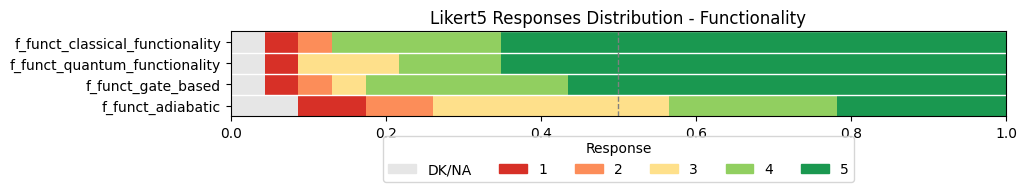

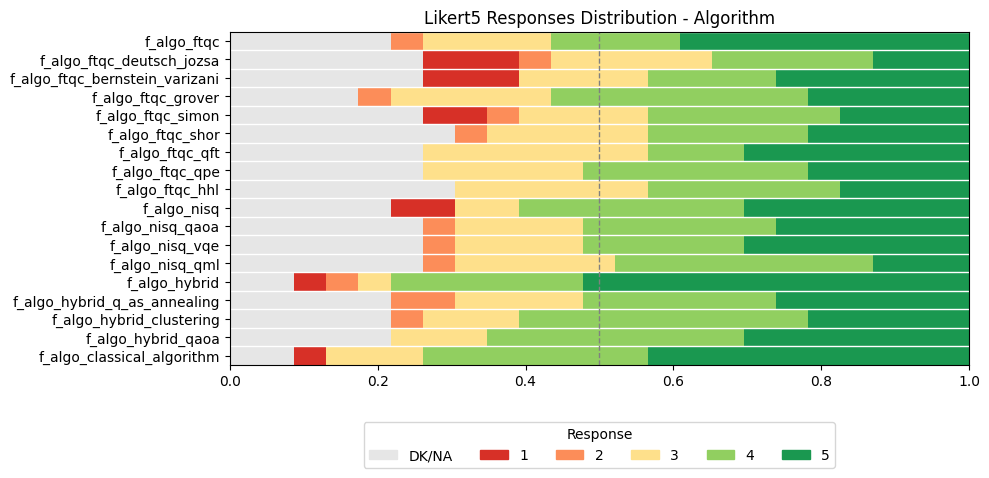

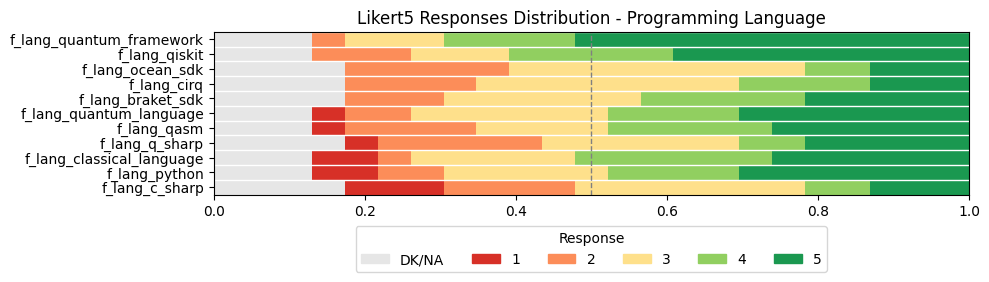

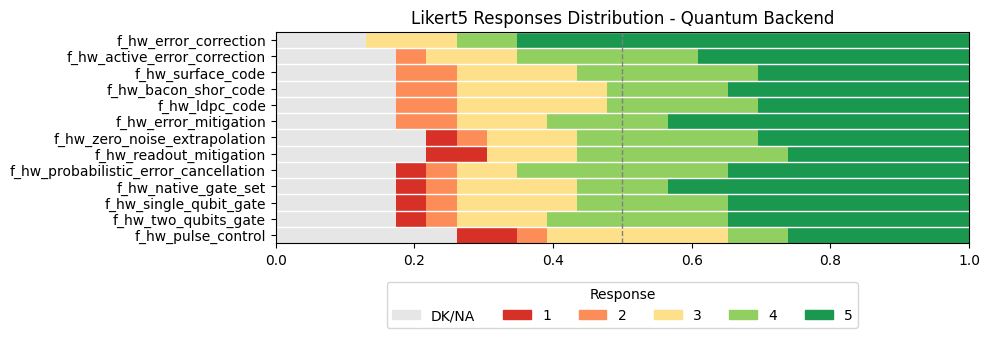

/tmp/ipython-input-3489345853.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


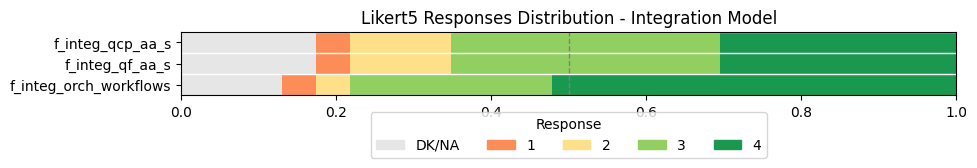

In [9]:
# Likert5 textual labels for legend
LIKERT_5_LABELS = ["DK/NA", "1", "2", "3", "4", "5"]

# Likert5 colors: DK/NA gray, 1 red → 5 green
LIKERT_5_COLORS = {
    0: "#e6e6e6",  # DK/NA gray
    1: "#d73027",  # red
    2: "#fc8d59",  # orange
    3: "#fee08b",  # amber
    4: "#91cf60",  # lime green
    5: "#1a9850",  # green
}

GEN_TITLE_MAP = {
    "gen_funct": "Functionality",
    "gen_algo": "Algorithm",
    "gen_lang": "Programming Language",
    "gen_hw": "Quantum Backend",
    "gen_integ": "Integration Model"
}

def plot_likert5_group_fixed_height(df, group_name, columns, bar_height_cm=0.6):
    """
    Plot 100% stacked horizontal bars for Likert5 variables,
    with fixed bar height (in cm) for all plots, no vertical gaps,
    and fully stacked.

    Parameters
    ----------
    df : pandas.DataFrame
        Processed DataFrame with numeric Likert5 columns
    group_name : str
        Name of the group
    columns : list
        List of Likert5 columns
    bar_height_cm : float
        Desired bar thickness in centimeters
    """
    if not columns:
        return

    df_group = df[columns]

    # Compute relative frequencies (percentages)
    df_percent = df_group.apply(lambda x: x.value_counts(normalize=True).sort_index()).fillna(0)
    df_percent = df_percent.T.iloc[::-1]  # reverse to have first variable at top

    n_vars = len(columns)

    # Convert bar height in cm to figure units
    dpi = 100  # figure dpi
    bar_height_inch = bar_height_cm / 2.54  # cm to inches
    fig_height = n_vars * bar_height_inch  # total figure height
    fig, ax = plt.subplots(figsize=(10, fig_height), dpi=dpi)

    # Plot stacked bars manually
    bottoms = np.zeros(n_vars)
    for val in sorted(df_percent.columns):
        ax.barh(
            y=np.arange(n_vars),
            width=df_percent[val],
            left=bottoms,
            color=LIKERT_5_COLORS.get(val, "#cccccc"),
            height=1.0
        )
        bottoms += df_percent[val].values

    # Add horizontal separator lines
    for y in range(n_vars):
        ax.hlines(y + 0.5, xmin=0, xmax=1, color='white', linestyle='-', linewidth=1)

    # Set limits and labels
    ax.set_ylim(-0.5, n_vars - 0.5)
    ax.set_xlim(0, 1)
    ax.set_yticks(np.arange(0, n_vars, 1))
    ax.set_yticklabels(df_percent.index)
    # ax.invert_yaxis()  # first variable at top

    # ax.set_xlabel("Proportion")
    # ax.set_ylabel("Variables")

    # Map raw group_name to natural-language title if available
    plot_title = GEN_TITLE_MAP.get(group_name, group_name)
    ax.set_title(f"Likert5 Responses Distribution - {plot_title}")

    # Vertical reference line at 50%
    ax.axvline(0.5, color="gray", linestyle="--", linewidth=1)

    # Legend below plot, horizontal
    handles = [plt.Rectangle((0,0),1,1,color=LIKERT_5_COLORS[v]) for v in sorted(df_percent.columns)]
    ax.legend(handles, LIKERT_5_LABELS, title="Response", loc='upper center',
              bbox_to_anchor=(0.5, -0.15), ncol=len(LIKERT_5_LABELS))

    plt.tight_layout()
    plt.show()


for group_name, cols in groups.items():
    plot_likert5_group_fixed_height(df, group_name, cols, bar_height_cm=0.7)


### features or intra-constraints without possitive valoration

**Statistical screening rationale (one-sided binomial test)**

**Goal.** For each Likert-5 item we quantify whether the item is *positively valued by users*. We define a response as *positive* if it is **4 or 5** on a 1–5 Likert scale. Let \(p\) be the true proportion of positive responses.

**Statistic.** We compute the empirical **positive rate**:
\[
\hat{p} = \frac{\#\{ \text{responses } \ge 4 \}}{\#\{\text{valid responses}\}}.
\]

**Hypothesis test (one-sided).**
- Null hypothesis \(H_0\): \(p = 0.50\) (the positive rate equals 50%).
- Alternative \(H_1\): \(p < 0.50\) (the positive rate is **below** 50%).

We run a **one-sided binomial test** with \(k\) = number of positive responses (4–5) and \(n\) = number of valid responses. The test returns a **p-value**:
- Small p-values (e.g., \(p < 0.05\)) provide evidence that the positive rate is **statistically below** 50%.

**Decision rule reported.**
- `valid_for_users = True` if \($\hat{p} \ge 0.50$).
- `valid_for_users = False` if \($\hat{p} < 0.50\$).
- We also report `significant_below_50` to indicate whether the test found \(\hat{p}\) **significantly** below 50% at \(\alpha=0.05\).

**Interpretation.**
- Items with `valid_for_users = False` are *not positively valued* according to the 50% criterion.
- If, in addition, `significant_below_50 = True`, the shortfall is statistically supported (one-sided binomial test).

**Notes.**
- Missing values and values outside {1,2,3,4,5} are ignored.
- You may adjust the threshold (e.g., 0.60) via `positive_threshold`, and the test level via `alpha`.
- If many items are tested, consider multiple-comparison corrections for formal inference in a confirmatory analysis.

In [10]:
# --- Screening of "positive for users" within pre-defined groups (from DATA_DICTIONARY) ---
# All code and comments in English.

import numpy as np
import pandas as pd
from scipy.stats import binomtest
from IPython.display import display, Markdown

def _likert5_positive_rate(series: pd.Series):
    """
    Compute counts and rate for Likert-5 where positive is {4,5}.
    Ignores NaN and values outside {1,2,3,4,5}.
    Returns: n_total, n_pos, pos_rate (float in [0,1]).
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    s = s[s.isin([1,2,3,4,5])]
    n = len(s)
    if n == 0:
        return 0, 0, np.nan
    n_pos = (s >= 4).sum()
    return n, n_pos, n_pos / n


def screen_valid_for_users_by_groups(df: pd.DataFrame,
                                     groups: "OrderedDict[str, list[str]]",
                                     alpha: float = 0.05,
                                     positive_threshold: float = 0.50,
                                     export_csv: bool = False):
    """
    For each group (as already discovered from DATA_DICTIONARY), compute:
      - positive_rate_4_5     (statistic)
      - one-sided binomial test p-value for H0: p = positive_threshold vs H1: p < threshold
      - decision valid_for_users: positive_rate_4_5 >= positive_threshold
      - significant_below_50: p-value < alpha (evidence of being below the threshold)

    Prints a table per group and returns a combined DataFrame with a 'group' column.
    """
    combined_rows = []

    # Iterate groups in the provided order (OrderedDict preserves your order)
    for gname, cols in groups.items():
        rows = []
        for col in cols:
            # Defensive: skip columns not present in df
            if col not in df.columns:
                rows.append({
                    "group": gname,
                    "variable": col,
                    "n": 0,
                    "positive_rate_4_5": np.nan,
                    f"p_value_pos_lt_{int(positive_threshold*100)}%": np.nan,
                    "valid_for_users": np.nan,
                    "significant_below_50": np.nan,
                    "note": "column not in df"
                })
                continue

            n, n_pos, pos_rate = _likert5_positive_rate(df[col])

            # Binomial one-sided test (only if we have data)
            if n > 0 and not np.isnan(pos_rate):
                pval = binomtest(k=n_pos, n=n, p=positive_threshold, alternative="less").pvalue
            else:
                pval = np.nan

            valid_for_users = (pos_rate >= positive_threshold) if not np.isnan(pos_rate) else np.nan
            significant_below = (pval < alpha) if not np.isnan(pval) else np.nan

            rows.append({
                "group": gname,
                "variable": col,
                "n": n,
                "positive_rate_4_5": pos_rate,
                f"p_value_pos_lt_{int(positive_threshold*100)}%": pval,
                "valid_for_users": valid_for_users,
                "significant_below_50": significant_below
            })

        group_df = pd.DataFrame(rows)

        # Pretty display (percentage as 0–100 with one decimal)
        to_show = group_df.copy()
        to_show["positive_rate_4_5"] = (to_show["positive_rate_4_5"] * 100).round(1)

        display(Markdown(f"### Group: `{gname}`"))
        display(
            to_show[[
                "variable",
                "n",
                "positive_rate_4_5",
                f"p_value_pos_lt_{int(positive_threshold*100)}%",
                "valid_for_users",
                "significant_below_50"
            ]].reset_index(drop=True)
        )

        if export_csv:
            safe_gname = "".join(ch if ch.isalnum() or ch in "_-" else "_" for ch in gname)
            to_show.to_csv(f"valid_for_users_screen_{safe_gname}.csv", index=False)

        combined_rows.append(group_df)

    # Return combined tidy DataFrame
    if combined_rows:
        combined = pd.concat(combined_rows, ignore_index=True)
        combined_display = combined.copy()
        combined_display["positive_rate_4_5"] = (combined_display["positive_rate_4_5"] * 100).round(1)
        return combined, combined_display
    else:
        return pd.DataFrame(), pd.DataFrame()


# ---------------------------
# USAGE (runs immediately):
# ---------------------------
# Assumes `df` and `groups` exist per your snippet above.
combined_raw, combined_pretty = screen_valid_for_users_by_groups(
    df=df,
    groups=groups,
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False  # set True to save per-group CSVs
)

# Optionally inspect or save the combined results:
# display(combined_pretty.sort_values(["group", "positive_rate_4_5"]))
# combined_pretty.to_csv("valid_for_users_screen_ALL_GROUPS.csv", index=False)


### Group: `gen_funct`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,22,90.9,0.999995,True,False
1,f_funct_quantum_functionality,22,81.8,0.999572,True,False
2,f_funct_gate_based,22,86.4,0.999939,True,False
3,f_funct_adiabatic,21,47.6,0.500000,False,False


### Group: `gen_algo`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,18,72.2,0.984558,True,False
1,f_algo_ftqc_deutsch_jozsa,17,47.1,0.500000,False,False
2,f_algo_ftqc_bernstein_varizani,17,58.8,0.833847,True,False
3,f_algo_ftqc_grover,19,68.4,0.968216,True,False
4,f_algo_ftqc_simon,17,58.8,0.833847,True,False
5,f_algo_ftqc_shor,16,62.5,0.894943,True,False
6,f_algo_ftqc_qft,17,58.8,0.833847,True,False
7,f_algo_ftqc_qpe,17,70.6,0.975479,True,False
8,f_algo_ftqc_hhl,16,62.5,0.894943,True,False
9,f_algo_nisq,18,77.8,0.996231,True,False


### Group: `gen_lang`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,20,80.0,0.998712,True,False
1,f_lang_qiskit,20,70.0,0.979305,True,False
2,f_lang_ocean_sdk,19,26.3,0.031784,False,True
3,f_lang_cirq,19,36.8,0.179642,False,False
4,f_lang_braket_sdk,19,52.6,0.676197,True,False
5,f_lang_quantum_language,20,55.0,0.748278,True,False
6,f_lang_qasm,20,55.0,0.748278,True,False
7,f_lang_q_sharp,19,36.8,0.179642,False,False
8,f_lang_classical_language,20,60.0,0.868412,True,False
9,f_lang_python,20,55.0,0.748278,True,False


### Group: `gen_hw`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,20,85.0,0.999799,True,False
1,f_hw_active_error_correction,19,78.9,0.997787,True,False
2,f_hw_surface_code,19,68.4,0.968216,True,False
3,f_hw_bacon_shor_code,19,63.2,0.916466,True,False
4,f_hw_ldpc_code,19,63.2,0.916466,True,False
5,f_hw_error_mitigation,19,73.7,0.990395,True,False
6,f_hw_zero_noise_extrapolation,18,72.2,0.984558,True,False
7,f_hw_readout_mitigation,18,72.2,0.984558,True,False
8,f_hw_probabilistic_error_cancellation,19,78.9,0.997787,True,False
9,f_hw_native_gate_set,19,68.4,0.968216,True,False


### Group: `gen_integ`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,19,78.9,0.997787,True,False
1,f_integ_qf_aa_s,19,78.9,0.997787,True,False
2,f_integ_orch_workflows,20,90.0,0.999980,True,False


### features or intra-constraints without possitive valoration (without begginers)

In [11]:
# --- Screening "valid for users" restricted by experience level (column: exp_q) ---
# All code and comments in English.

import numpy as np
import pandas as pd
from scipy.stats import binomtest
from IPython.display import display, Markdown

# We reuse _likert5_positive_rate from your previous cell.
# If it is not in scope for some reason, uncomment this definition:
# def _likert5_positive_rate(series: pd.Series):
#     s = pd.to_numeric(series, errors="coerce").dropna()
#     s = s[s.isin([1,2,3,4,5])]
#     n = len(s)
#     if n == 0:
#         return 0, 0, np.nan
#     n_pos = (s >= 4).sum()
#     return n, n_pos, n_pos / n

def screen_valid_for_users_by_groups_with_experience(df: pd.DataFrame,
                                                     groups: "OrderedDict[str, list[str]]",
                                                     exp_col: str = "exp_q",
                                                     include_levels=None,
                                                     alpha: float = 0.05,
                                                     positive_threshold: float = 0.50,
                                                     export_csv: bool = False,
                                                     title_suffix: str = ""):
    """
    Run the same screening as 'screen_valid_for_users_by_groups' but on a filtered subset
    of respondents according to the experience column `exp_col`.

    Parameters
    ----------
    df : pd.DataFrame
        Full survey dataframe.
    groups : OrderedDict[str, list[str]]
        Groups and their Likert-5 variables (features only).
    exp_col : str
        Column holding respondent experience text labels (e.g., "exp_q").
    include_levels : list[str] or None
        Which textual levels to keep. If None, defaults to excluding only "Beginner (0-1 years)"
        and keeping Intermediate, Advanced, and Expert.
        Examples:
          - None (default): keep non-beginners only.
          - ["Expert (7+ years)"]: keep experts only.
          - ["Intermediate (1-3 years)", "Advanced (3-5 years)", "Expert (7+ years)"]: explicit non-beginners.
    alpha : float
        Significance level for the one-sided binomial test.
    positive_threshold : float
        Threshold for the positive rate (>= 4 on Likert-5) to declare valid_for_users.
    export_csv : bool
        If True, saves per-group CSVs of the pretty table.
    title_suffix : str
        Optional string appended to the per-group title to indicate the filter used.

    Returns
    -------
    combined_raw : pd.DataFrame
        Tidy numeric results across all groups (subset-filtered).
    combined_display : pd.DataFrame
        Human-friendly copy with percentages in [0,100].
    """
    # Define canonical labels (as per your provided examples)
    NON_BEGINNER_DEFAULT = [
        "Intermediate (1-3 years)",
        "Advanced (3-5 years)",
        "Expert (7+ years)"
    ]

    if include_levels is None:
        include_levels = NON_BEGINNER_DEFAULT

    # Filter dataframe by experience
    if exp_col not in df.columns:
        raise KeyError(f"Column '{exp_col}' not found in df.")

    df_filt = df[df[exp_col].isin(include_levels)].copy()

    # Report the filter being used
    display(Markdown(
        f"**Experience filter applied** on `{exp_col}`: {', '.join(include_levels)}  "
        f"(n = {len(df_filt)})"
    ))

    combined_rows = []

    for gname, cols in groups.items():
        rows = []
        for col in cols:
            if col not in df_filt.columns:
                rows.append({
                    "group": gname,
                    "variable": col,
                    "n": 0,
                    "positive_rate_4_5": np.nan,
                    f"p_value_pos_lt_{int(positive_threshold*100)}%": np.nan,
                    "valid_for_users": np.nan,
                    "significant_below_50": np.nan,
                    "note": "column not in filtered df"
                })
                continue

            n, n_pos, pos_rate = _likert5_positive_rate(df_filt[col])

            if n > 0 and not np.isnan(pos_rate):
                pval = binomtest(k=n_pos, n=n, p=positive_threshold, alternative="less").pvalue
            else:
                pval = np.nan

            valid_for_users = (pos_rate >= positive_threshold) if not np.isnan(pos_rate) else np.nan
            significant_below = (pval < alpha) if not np.isnan(pval) else np.nan

            rows.append({
                "group": gname,
                "variable": col,
                "n": n,
                "positive_rate_4_5": pos_rate,
                f"p_value_pos_lt_{int(positive_threshold*100)}%": pval,
                "valid_for_users": valid_for_users,
                "significant_below_50": significant_below
            })

        group_df = pd.DataFrame(rows)

        # Pretty display (percentage as 0–100 with one decimal)
        to_show = group_df.copy()
        to_show["positive_rate_4_5"] = (to_show["positive_rate_4_5"] * 100).round(1)

        subtitle = title_suffix.strip()
        hdr = f"### Group: `{gname}`"
        if subtitle:
            hdr += f" — {subtitle}"

        display(Markdown(hdr))
        display(
            to_show[[
                "variable",
                "n",
                "positive_rate_4_5",
                f"p_value_pos_lt_{int(positive_threshold*100)}%",
                "valid_for_users",
                "significant_below_50"
            ]].reset_index(drop=True)
        )

        if export_csv:
            def _safe(s): return "".join(ch if ch.isalnum() or ch in "_-" else "_" for ch in str(s))
            safe_gname = _safe(gname)
            safe_suffix = _safe(subtitle) if subtitle else "filtered"
            to_show.to_csv(f"valid_for_users_screen_{safe_gname}_{safe_suffix}.csv", index=False)

        combined_rows.append(group_df)

    if combined_rows:
        combined = pd.concat(combined_rows, ignore_index=True)
        combined_display = combined.copy()
        combined_display["positive_rate_4_5"] = (combined_display["positive_rate_4_5"] * 100).round(1)
        return combined, combined_display
    else:
        return pd.DataFrame(), pd.DataFrame()


# ---------------------------
# USAGE EXAMPLES
# ---------------------------

# A) Non-beginners only (default): Intermediate + Advanced + Expert
combined_raw_nb, combined_pretty_nb = screen_valid_for_users_by_groups_with_experience(
    df=df,
    groups=groups,
    exp_col="exp_q",
    include_levels=None,                   # None -> keeps Intermediate, Advanced, Expert
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False,
    title_suffix="non-beginners only"
)

# B) Experts only
combined_raw_expert, combined_pretty_expert = screen_valid_for_users_by_groups_with_experience(
    df=df,
    groups=groups,
    exp_col="exp_q",
    include_levels=["Expert (7+ years)"],  # keep only Experts
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False,
    title_suffix="experts only"
)

# C) Intermediate + Advanced (exclude both Beginners and Experts), if ever needed:
# combined_raw_ia, combined_pretty_ia = screen_valid_for_users_by_groups_with_experience(
#     df=df,
#     groups=groups,
#     exp_col="exp_q",
#     include_levels=["Intermediate (1-3 years)", "Advanced (3-5 years)"],
#     alpha=0.05,
#     positive_threshold=0.50,
#     export_csv=False,
#     title_suffix="intermediate & advanced"
# )

**Experience filter applied** on `exp_q`: Intermediate (1-3 years), Advanced (3-5 years), Expert (7+ years)  (n = 21)

### Group: `gen_funct` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,20,95.0,0.999999,True,False
1,f_funct_quantum_functionality,20,85.0,0.999799,True,False
2,f_funct_gate_based,20,90.0,0.999980,True,False
3,f_funct_adiabatic,19,47.4,0.500000,False,False


### Group: `gen_algo` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,18,72.2,0.984558,True,False
1,f_algo_ftqc_deutsch_jozsa,17,47.1,0.500000,False,False
2,f_algo_ftqc_bernstein_varizani,17,58.8,0.833847,True,False
3,f_algo_ftqc_grover,19,68.4,0.968216,True,False
4,f_algo_ftqc_simon,17,58.8,0.833847,True,False
5,f_algo_ftqc_shor,16,62.5,0.894943,True,False
6,f_algo_ftqc_qft,17,58.8,0.833847,True,False
7,f_algo_ftqc_qpe,17,70.6,0.975479,True,False
8,f_algo_ftqc_hhl,16,62.5,0.894943,True,False
9,f_algo_nisq,18,77.8,0.996231,True,False


### Group: `gen_lang` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,20,80.0,0.998712,True,False
1,f_lang_qiskit,20,70.0,0.979305,True,False
2,f_lang_ocean_sdk,19,26.3,0.031784,False,True
3,f_lang_cirq,19,36.8,0.179642,False,False
4,f_lang_braket_sdk,19,52.6,0.676197,True,False
5,f_lang_quantum_language,20,55.0,0.748278,True,False
6,f_lang_qasm,20,55.0,0.748278,True,False
7,f_lang_q_sharp,19,36.8,0.179642,False,False
8,f_lang_classical_language,20,60.0,0.868412,True,False
9,f_lang_python,20,55.0,0.748278,True,False


### Group: `gen_hw` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,20,85.0,0.999799,True,False
1,f_hw_active_error_correction,19,78.9,0.997787,True,False
2,f_hw_surface_code,19,68.4,0.968216,True,False
3,f_hw_bacon_shor_code,19,63.2,0.916466,True,False
4,f_hw_ldpc_code,19,63.2,0.916466,True,False
5,f_hw_error_mitigation,19,73.7,0.990395,True,False
6,f_hw_zero_noise_extrapolation,18,72.2,0.984558,True,False
7,f_hw_readout_mitigation,18,72.2,0.984558,True,False
8,f_hw_probabilistic_error_cancellation,19,78.9,0.997787,True,False
9,f_hw_native_gate_set,19,68.4,0.968216,True,False


### Group: `gen_integ` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,19,78.9,0.997787,True,False
1,f_integ_qf_aa_s,19,78.9,0.997787,True,False
2,f_integ_orch_workflows,20,90.0,0.999980,True,False


**Experience filter applied** on `exp_q`: Expert (7+ years)  (n = 1)

### Group: `gen_funct` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,1,100.0,1.0,True,False
1,f_funct_quantum_functionality,1,100.0,1.0,True,False
2,f_funct_gate_based,1,100.0,1.0,True,False
3,f_funct_adiabatic,1,100.0,1.0,True,False


### Group: `gen_algo` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,1,100.0,1.0,True,False
1,f_algo_ftqc_deutsch_jozsa,1,100.0,1.0,True,False
2,f_algo_ftqc_bernstein_varizani,1,100.0,1.0,True,False
3,f_algo_ftqc_grover,1,100.0,1.0,True,False
4,f_algo_ftqc_simon,1,100.0,1.0,True,False
5,f_algo_ftqc_shor,1,100.0,1.0,True,False
6,f_algo_ftqc_qft,1,100.0,1.0,True,False
7,f_algo_ftqc_qpe,1,100.0,1.0,True,False
8,f_algo_ftqc_hhl,1,100.0,1.0,True,False
9,f_algo_nisq,1,100.0,1.0,True,False


### Group: `gen_lang` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,1,100.0,1.0,True,False
1,f_lang_qiskit,1,100.0,1.0,True,False
2,f_lang_ocean_sdk,1,100.0,1.0,True,False
3,f_lang_cirq,1,100.0,1.0,True,False
4,f_lang_braket_sdk,1,100.0,1.0,True,False
5,f_lang_quantum_language,1,0.0,0.5,False,False
6,f_lang_qasm,1,0.0,0.5,False,False
7,f_lang_q_sharp,1,0.0,0.5,False,False
8,f_lang_classical_language,1,0.0,0.5,False,False
9,f_lang_python,1,0.0,0.5,False,False


### Group: `gen_hw` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,1,0.0,0.5,False,False
1,f_hw_active_error_correction,1,0.0,0.5,False,False
2,f_hw_surface_code,1,0.0,0.5,False,False
3,f_hw_bacon_shor_code,1,0.0,0.5,False,False
4,f_hw_ldpc_code,1,0.0,0.5,False,False
5,f_hw_error_mitigation,1,0.0,0.5,False,False
6,f_hw_zero_noise_extrapolation,1,0.0,0.5,False,False
7,f_hw_readout_mitigation,1,0.0,0.5,False,False
8,f_hw_probabilistic_error_cancellation,1,0.0,0.5,False,False
9,f_hw_native_gate_set,1,0.0,0.5,False,False


### Group: `gen_integ` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,1,100.0,1.0,True,False
1,f_integ_qf_aa_s,1,100.0,1.0,True,False
2,f_integ_orch_workflows,1,100.0,1.0,True,False


##**7.** Reliability and Stability Analysis of Expert Judgements

This section evaluates the reliability, agreement, and statistical robustness of the experts’ assessments on the relevance of the proposed features and constraints of the hybrid quantum–classical Feature Model (FM). Because the study is exploratory and the expert panel is heterogeneous in background, we do not rely on internal-consistency metrics; instead, we focus on inter-expert agreement and item-level evidence of support. The analysis proceeds in three main steps:

---

**1. Inter-Rater Reliability (IRR): Fleiss’ Kappa and Krippendorff’s Alpha**

We compute two standard multi-rater agreement statistics:

- **Fleiss’ Kappa** — measures categorical agreement beyond chance.  
- **Krippendorff’s Alpha (ordinal)** — robust to missing data and suitable for Likert-scale judgements.

These metrics are reported:
- **globally**,  
- **for each FM sub-tree**,  
- **and for subgroups of experts** (e.g., experience in QC/SPL, role, QC areas, development phase),  
including proper handling of multi-valued categorical variables (e.g., multiple phases or QC areas selected).

Given the diversity of expertise, low agreement is expected; the purpose is to quantify differences and identify domains where disagreement is systematic.

---

**2. Item-Level Support: Positive-Response Rate and I-CVI**

For each proposed feature and constraint, we compute:

- the **proportion of positive responses** (ratings ≥ 4),  
- the **Item Content Validity Index (I-CVI)**, identical to the above and widely used in expert-judgement studies.

Because this is an exploratory evaluation of a conceptual model, we adopt inclusive interpretive thresholds:

- **Accepted**: point estimate ≥ 0.65  
- **Limited evidence**: point estimate in [0.55, 0.65) or high uncertainty  
- **Questionable**: CI_high < 0.55  

These values quantify the extent to which experts consider each FM element relevant.

---

**3. Bootstrap Stability Analysis (1,000 resamples)**

To assess the robustness of the estimated support for each item, we perform a **non-parametric bootstrap**:

- resampling respondents with replacement (B = 1,000),  
- recomputing the proportion of positive responses each time,  
- and obtaining a **95% bootstrap confidence interval (CI)**.

This analysis reveals whether an item’s support is:
- **stable** (narrow CI well above 0.65),  
- **borderline or uncertain** (CI crosses 0.55–0.65),  
- **consistently weak** (CI entirely below 0.55).

This step is essential to determine whether the observed support is robust or driven by sampling variability.

---

**4. Visual Summary: Traffic-Light Forest Plots**

For each FM group, we present a compact forest plot showing:
- the **point estimate** of expert support,  
- the **95% bootstrap CI**,  
- and a **traffic-light classification**:
  - **green** (accepted),  
  - **amber** (limited evidence),  
  - **red** (questionable).

Items are ordered from strongest to weakest support, and plots are formatted to maintain consistent data-area width regardless of label length.

---

**Outcome**

Together, these analyses provide a structured, statistically grounded assessment of the experts’ evaluations. They identify:
- features with robust evidence of relevance,  
- features requiring refinement or clearer definition,  
- and features with insufficient support.

This reliability and stability assessment directly informs the consolidation and refinement of the proposed Feature Model.


### 1. Descriptive statistics per item (Likert-based validation of FM features)

In this section we summarise each survey item that evaluates **the relevance of a feature or constraint in the Feature Model**.

For each Likert item we report:

- `N_total`: number of non-missing responses (including DK/NA).  
- `N_valid`: number of responses excluding DK/NA (i.e., values > 0).  
- `DKNA_%`: percentage of “Don’t know / Not applicable” answers (coded as 0).  
- `mean`, `median`, `sd`: descriptive statistics on the **valid** responses (1–5 or 1–3).  
- `%neg`: percentage of negative answers (1–2 in Likert-5; 1 in Likert-3).  
- `%neutral`: percentage of neutral answers (3 in Likert-5; 2 in Likert-3).  
- `%pos`: percentage of positive answers (4–5 in Likert-5; 3 in Likert-3).

We treat DK/NA as “informative non-endorsement”: it is reported in `DKNA_%` but excluded from the computation of mean/median and from the negative/neutral/positive percentages.

### * Descriptive statistics grouped by FM dimension

Using the grouped structure automatically derived from `DATA_DICTIONARY`, we present below the descriptive statistics for all Likert-5 items (features and constraints excluded) grouped under:

- `gen_funct`: Functional capabilities  
- `gen_algo`: Algorithmic paradigms  
- `gen_lang`: Frameworks and languages  
- `gen_hw`: Hardware, error models, control  
- `gen_integ`: Integration and orchestration

Each table reports:  
`N_total`, `N_valid`, `DKNA_%`, `mean`, `median`, `sd`, `%neg`, `%neutral`, `%pos`.


In [12]:
# 1. Identify Likert-5 and Likert-3 columns from DATA_DICTIONARY

from IPython.display import display

# All Likert-5 and Likert-3 variables present in df
LIKERT5_COLS = [
    col for col, typ in DATA_DICTIONARY.items()
    if typ == "likert5" and col in df.columns
]

LIKERT3_COLS = [
    col for col, typ in DATA_DICTIONARY.items()
    if typ == "likert3" and col in df.columns
]

print("Total Likert-5 columns:", len(LIKERT5_COLS))
print("Total Likert-3 columns:", len(LIKERT3_COLS))

# Optional: restrict to FM-related features/constraints only
# (you can comment this out if you prefer to include all Likert vars)
FM_LIKERT5_COLS = [
    c for c in LIKERT5_COLS
    if c.startswith(("f_", "c_"))   # heuristic for features/constraints
]

FM_LIKERT3_COLS = [
    c for c in LIKERT3_COLS
    if c.startswith(("gen_", "ccc_", "gen_"))  # e.g., general questions about the FM
]

print("FM Likert-5 columns:", len(FM_LIKERT5_COLS))
print("FM Likert-3 columns:", len(FM_LIKERT3_COLS))


Total Likert-5 columns: 56
Total Likert-3 columns: 22
FM Likert-5 columns: 55
FM Likert-3 columns: 22


In [13]:
import numpy as np
import pandas as pd

def describe_likert_items(
    df: pd.DataFrame,
    cols,
    *,
    positive_threshold: int,
    neutral_value: int | None,
    label: str = "likert"
) -> pd.DataFrame:
    """
    Build descriptive statistics for Likert items.

    Assumptions:
    - DK/NA is coded as 0.
    - Valid responses are >0.
    - For Likert-5:
        negative = {1, 2}, neutral = {3}, positive = {4, 5}
    - For Likert-3:
        negative = {1}, neutral = {2}, positive = {3}
    """
    rows = []

    for col in cols:
        if col not in df.columns:
            continue

        s = pd.to_numeric(df[col], errors="coerce")

        # Total responses (including DK/NA)
        total_non_missing = s.notna().sum()

        # DK/NA
        dkna_count = (s == 0).sum()

        # Valid Likert responses
        valid = s[s > 0].dropna()
        n_valid = valid.shape[0]

        if total_non_missing == 0:
            # Nothing answered at all for this item
            rows.append({
                "item": col,
                "scale": label,
                "N_total": 0,
                "N_valid": 0,
                "DKNA_%": np.nan,
                "mean": np.nan,
                "median": np.nan,
                "sd": np.nan,
                "%neg": np.nan,
                "%neutral": np.nan,
                "%pos": np.nan,
            })
            continue

        # Descriptive statistics on valid answers
        if n_valid > 0:
            mean = valid.mean()
            median = valid.median()
            sd = valid.std(ddof=1)
        else:
            mean = median = sd = np.nan

        # Negative / neutral / positive counts (on valid responses)
        if n_valid > 0:
            # Negative
            if neutral_value is not None:
                neg_mask = (valid >= 1) & (valid <= neutral_value - 1)
            else:
                neg_mask = valid == 1  # very conservative default
            neg_count = neg_mask.sum()

            # Neutral
            if neutral_value is not None:
                neut_mask = (valid == neutral_value)
                neut_count = neut_mask.sum()
            else:
                neut_count = 0

            # Positive
            pos_mask = (valid >= positive_threshold)
            pos_count = pos_mask.sum()

            # Percentages over valid responses
            denom = float(n_valid)
            neg_pct = 100.0 * neg_count / denom
            neut_pct = 100.0 * neut_count / denom
            pos_pct = 100.0 * pos_count / denom
        else:
            neg_pct = neut_pct = pos_pct = np.nan

        dkna_pct = 100.0 * dkna_count / float(total_non_missing)

        rows.append({
            "item": col,
            "scale": label,
            "N_total": int(total_non_missing),
            "N_valid": int(n_valid),
            "DKNA_%": round(dkna_pct, 1),
            "mean": round(mean, 2) if not np.isnan(mean) else np.nan,
            "median": median if not np.isnan(median) else np.nan,
            "sd": round(sd, 2) if not np.isnan(sd) else np.nan,
            "%neg": round(neg_pct, 1) if not np.isnan(neg_pct) else np.nan,
            "%neutral": round(neut_pct, 1) if not np.isnan(neut_pct) else np.nan,
            "%pos": round(pos_pct, 1) if not np.isnan(pos_pct) else np.nan,
        })

    out = pd.DataFrame(rows)
    # Optional: sort by descending %pos to see most-endorsed features first
    if "%pos" in out.columns:
        out = out.sort_values(by="%pos", ascending=False)
    return out.reset_index(drop=True)


In [14]:
# 2. Descriptive tables for the Feature Model items

desc_fm_likert5 = describe_likert_items(
    df,
    FM_LIKERT5_COLS,
    positive_threshold=4,   # 4–5 = agreement
    neutral_value=3,
    label="likert5"
)

desc_fm_likert3 = describe_likert_items(
    df,
    FM_LIKERT3_COLS,
    positive_threshold=3,   # 3 = Yes
    neutral_value=2,        # 2 = Partially
    label="likert3"
)

print("=== Descriptives for FM Likert-5 items ===")
display(desc_fm_likert5)

print("\n=== Descriptives for FM Likert-3 items ===")
display(desc_fm_likert3)


=== Descriptives for FM Likert-5 items ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_funct_classical_functionality,likert5,23,22,4.3,4.45,5.0,1.06,9.1,0.0,90.9
1,f_integ_orch_workflows,likert5,23,20,13.0,4.45,5.0,0.83,5.0,5.0,90.0
2,f_funct_gate_based,likert5,23,22,4.3,4.32,5.0,1.09,9.1,4.5,86.4
3,f_algo_hybrid,likert5,23,21,8.7,4.29,5.0,1.10,9.5,4.8,85.7
4,f_hw_error_correction,likert5,23,20,13.0,4.60,5.0,0.75,0.0,15.0,85.0
5,f_algo_hybrid_qaoa,likert5,23,18,21.7,4.22,4.0,0.73,0.0,16.7,83.3
6,f_funct_quantum_functionality,likert5,23,22,4.3,4.41,5.0,1.05,4.5,13.6,81.8
7,f_algo_classical_algorithm,likert5,23,21,8.7,4.19,4.0,1.03,4.8,14.3,81.0
8,f_lang_quantum_framework,likert5,23,20,13.0,4.35,5.0,0.93,5.0,15.0,80.0
9,f_hw_active_error_correction,likert5,23,19,17.4,4.21,4.0,0.92,5.3,15.8,78.9



=== Descriptives for FM Likert-3 items ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,ccc_integ_3,likert3,23,20,13.0,2.70,3.0,0.73,15.0,0.0,85.0
1,ccc_algo_3,likert3,23,19,17.4,2.79,3.0,0.54,5.3,10.5,84.2
2,ccc_algo_2,likert3,23,19,17.4,2.84,3.0,0.37,0.0,15.8,84.2
3,gen_funct,likert3,23,23,0.0,2.83,3.0,0.39,0.0,17.4,82.6
4,gen_integ,likert3,23,23,0.0,2.74,3.0,0.62,8.7,8.7,82.6
5,ccc_algo_4,likert3,23,19,17.4,2.74,3.0,0.56,5.3,15.8,78.9
6,ccc_integ_1,likert3,23,18,21.7,2.56,3.0,0.86,22.2,0.0,77.8
7,ccc_lang_1,likert3,23,20,13.0,2.60,3.0,0.75,15.0,10.0,75.0
8,ccc_lang_2,likert3,23,19,17.4,2.58,3.0,0.77,15.8,10.5,73.7
9,ccc_lang_3,likert3,23,19,17.4,2.58,3.0,0.77,15.8,10.5,73.7


In [15]:
# Helper function to show one group
def show_group_table(desc_table, group_name, cols):
    subset = desc_table[desc_table["item"].isin(cols)]
    print(f"\n=== {group_name} ({len(subset)} items) ===")
    display(subset.reset_index(drop=True))


# Iterate over detected groups in the correct order
for group_name, cols in groups.items():
    show_group_table(desc_fm_likert5, group_name, cols)



=== gen_funct (4 items) ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_funct_classical_functionality,likert5,23,22,4.3,4.45,5.0,1.06,9.1,0.0,90.9
1,f_funct_gate_based,likert5,23,22,4.3,4.32,5.0,1.09,9.1,4.5,86.4
2,f_funct_quantum_functionality,likert5,23,22,4.3,4.41,5.0,1.05,4.5,13.6,81.8
3,f_funct_adiabatic,likert5,23,21,8.7,3.43,3.0,1.25,19.0,33.3,47.6



=== gen_algo (18 items) ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_algo_hybrid,likert5,23,21,8.7,4.29,5.0,1.10,9.5,4.8,85.7
1,f_algo_hybrid_qaoa,likert5,23,18,21.7,4.22,4.0,0.73,0.0,16.7,83.3
2,f_algo_classical_algorithm,likert5,23,21,8.7,4.19,4.0,1.03,4.8,14.3,81.0
3,f_algo_hybrid_clustering,likert5,23,18,21.7,4.00,4.0,0.84,5.6,16.7,77.8
4,f_algo_nisq,likert5,23,18,21.7,3.94,4.0,1.26,11.1,11.1,77.8
5,f_algo_ftqc,likert5,23,18,21.7,4.17,4.5,0.99,5.6,22.2,72.2
6,f_algo_nisq_qaoa,likert5,23,17,26.1,4.00,4.0,0.94,5.9,23.5,70.6
7,f_algo_ftqc_qpe,likert5,23,17,26.1,4.00,4.0,0.79,0.0,29.4,70.6
8,f_algo_nisq_vqe,likert5,23,17,26.1,4.06,4.0,0.97,5.9,23.5,70.6
9,f_algo_ftqc_grover,likert5,23,19,17.4,3.89,4.0,0.88,5.3,26.3,68.4



=== gen_lang (11 items) ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_lang_quantum_framework,likert5,23,20,13.0,4.35,5.0,0.93,5.0,15.0,80.0
1,f_lang_qiskit,likert5,23,20,13.0,4.00,4.0,1.12,15.0,15.0,70.0
2,f_lang_classical_language,likert5,23,20,13.0,3.65,4.0,1.27,15.0,25.0,60.0
3,f_lang_qasm,likert5,23,20,13.0,3.55,4.0,1.28,25.0,20.0,55.0
4,f_lang_python,likert5,23,20,13.0,3.60,4.0,1.35,20.0,25.0,55.0
5,f_lang_quantum_language,likert5,23,20,13.0,3.70,4.0,1.22,15.0,30.0,55.0
6,f_lang_braket_sdk,likert5,23,19,17.4,3.63,4.0,1.07,15.8,31.6,52.6
7,f_lang_q_sharp,likert5,23,19,17.4,3.26,3.0,1.28,31.6,31.6,36.8
8,f_lang_cirq,likert5,23,19,17.4,3.32,3.0,1.00,21.1,42.1,36.8
9,f_lang_c_sharp,likert5,23,19,17.4,2.89,3.0,1.29,36.8,36.8,26.3



=== gen_hw (13 items) ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_hw_error_correction,likert5,23,20,13.0,4.60,5.0,0.75,0.0,15.0,85.0
1,f_hw_active_error_correction,likert5,23,19,17.4,4.21,4.0,0.92,5.3,15.8,78.9
2,f_hw_probabilistic_error_cancellation,likert5,23,19,17.4,4.05,4.0,1.13,10.5,10.5,78.9
3,f_hw_two_qubits_gate,likert5,23,19,17.4,4.00,4.0,1.15,10.5,15.8,73.7
4,f_hw_error_mitigation,likert5,23,19,17.4,4.16,5.0,1.07,10.5,15.8,73.7
5,f_hw_readout_mitigation,likert5,23,18,21.7,3.83,4.0,1.25,11.1,16.7,72.2
6,f_hw_zero_noise_extrapolation,likert5,23,18,21.7,3.94,4.0,1.16,11.1,16.7,72.2
7,f_hw_single_qubit_gate,likert5,23,19,17.4,3.95,4.0,1.18,10.5,21.1,68.4
8,f_hw_surface_code,likert5,23,19,17.4,3.95,4.0,1.03,10.5,21.1,68.4
9,f_hw_native_gate_set,likert5,23,19,17.4,4.05,5.0,1.22,10.5,21.1,68.4



=== gen_integ (3 items) ===


,item,scale,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos
0,f_integ_orch_workflows,likert5,23,20,13.0,4.45,5.0,0.83,5.0,5.0,90.0
1,f_integ_qcp_aa_s,likert5,23,19,17.4,4.11,4.0,0.88,5.3,15.8,78.9
2,f_integ_qf_aa_s,likert5,23,19,17.4,4.11,4.0,0.88,5.3,15.8,78.9


### 2. Content Validity Index (CVI)

To assess whether each feature of the Feature Model is considered *relevant* by the experts, we compute:

- **I-CVI (Item-Level Content Validity Index):**  
  Proportion of experts rating the item as *relevant*.  
  For Likert-5 scales, relevance is defined as responses `4` or `5`.

- **S-CVI/Ave (Scale-Level CVI):**  
  Average I-CVI across all items within each FM dimension (`gen_funct`, `gen_algo`, `gen_lang`, `gen_hw`, `gen_integ`).

Interpretation follows Lynn (1986):  
- `I-CVI ≥ 0.78` → the item is considered valid by experts.  

We also report:  
- `N_valid`: number of raters with valid responses (excluding DK/NA).  
- `%pos`: percentage of raters selecting `4` or `5`.  

**Rationale:** “Twenty-six experts participated in the content validation. Given the exploratory nature of the study and the highly specialised domain (hybrid quantum–classical software), we followed Polit and Beck’s recommendations and adopted an I-CVI threshold of 0.70 for item acceptance, which is appropriate for expert-based conceptual validation with larger expert panels.

Items with I-CVI ≥ 0.70 were considered as having high content validity. Items with 0.60 ≤ I-CVI < 0.70 were classified as having moderate validity and marked for revision. Items with I-CVI < 0.60 were considered to have low content validity and were candidates for exclusion from the final Feature Model.”


In [16]:
def compute_icvi(
    df,
    cols,
    positive_threshold=4,
    accept_threshold=0.70,
    review_threshold=0.60
):
    """
    Compute I-CVI and positive response ratios for each Likert-5 item.

    Classification:
        - 'accepted'  : I-CVI >= accept_threshold
        - 'review'    : review_threshold <= I-CVI < accept_threshold
        - 'rejected'  : I-CVI < review_threshold
    """
    rows = []

    for col in cols:
        if col not in df.columns:
            continue

        s = pd.to_numeric(df[col], errors="coerce")

        valid = s[s > 0]               # remove DK/NA
        n_valid = valid.shape[0]

        if n_valid == 0:
            rows.append({
                "item": col,
                "N_valid": 0,
                "I-CVI": np.nan,
                "%pos": np.nan,
                "status": "no_data"
            })
            continue

        pos = (valid >= positive_threshold).sum()
        i_cvi = pos / n_valid
        pct_pos = 100 * i_cvi

        # Classification according to thresholds
        if i_cvi >= accept_threshold:
            status = "accepted"
        elif i_cvi >= review_threshold:
            status = "review"
        else:
            status = "rejected"

        rows.append({
            "item": col,
            "N_valid": n_valid,
            "I-CVI": round(i_cvi, 3),
            "%pos": round(pct_pos, 1),
            "status": status
        })

    return pd.DataFrame(rows).sort_values(by="I-CVI", ascending=False).reset_index(drop=True)


# Compute I-CVI for all Likert-5 "f_" items grouped under `groups`
icvi_results = {}
for group_name, cols in groups.items():
    icvi_results[group_name] = compute_icvi(df, cols)

# Example output
for group, table in icvi_results.items():
    print(f"\n=== I-CVI for group: {group} ===")
    display(table)



=== I-CVI for group: gen_funct ===


,item,N_valid,I-CVI,%pos,status
0,f_funct_classical_functionality,22,0.909,90.9,accepted
1,f_funct_gate_based,22,0.864,86.4,accepted
2,f_funct_quantum_functionality,22,0.818,81.8,accepted
3,f_funct_adiabatic,21,0.476,47.6,rejected



=== I-CVI for group: gen_algo ===


,item,N_valid,I-CVI,%pos,status
0,f_algo_hybrid,21,0.857,85.7,accepted
1,f_algo_hybrid_qaoa,18,0.833,83.3,accepted
2,f_algo_classical_algorithm,21,0.810,81.0,accepted
3,f_algo_nisq,18,0.778,77.8,accepted
4,f_algo_hybrid_clustering,18,0.778,77.8,accepted
5,f_algo_ftqc,18,0.722,72.2,accepted
6,f_algo_nisq_vqe,17,0.706,70.6,accepted
7,f_algo_ftqc_qpe,17,0.706,70.6,accepted
8,f_algo_nisq_qaoa,17,0.706,70.6,accepted
9,f_algo_ftqc_grover,19,0.684,68.4,review



=== I-CVI for group: gen_lang ===


,item,N_valid,I-CVI,%pos,status
0,f_lang_quantum_framework,20,0.800,80.0,accepted
1,f_lang_qiskit,20,0.700,70.0,accepted
2,f_lang_classical_language,20,0.600,60.0,review
3,f_lang_python,20,0.550,55.0,rejected
4,f_lang_qasm,20,0.550,55.0,rejected
5,f_lang_quantum_language,20,0.550,55.0,rejected
6,f_lang_braket_sdk,19,0.526,52.6,rejected
7,f_lang_q_sharp,19,0.368,36.8,rejected
8,f_lang_cirq,19,0.368,36.8,rejected
9,f_lang_ocean_sdk,19,0.263,26.3,rejected



=== I-CVI for group: gen_hw ===


,item,N_valid,I-CVI,%pos,status
0,f_hw_error_correction,20,0.850,85.0,accepted
1,f_hw_active_error_correction,19,0.789,78.9,accepted
2,f_hw_probabilistic_error_cancellation,19,0.789,78.9,accepted
3,f_hw_error_mitigation,19,0.737,73.7,accepted
4,f_hw_two_qubits_gate,19,0.737,73.7,accepted
5,f_hw_readout_mitigation,18,0.722,72.2,accepted
6,f_hw_zero_noise_extrapolation,18,0.722,72.2,accepted
7,f_hw_surface_code,19,0.684,68.4,review
8,f_hw_native_gate_set,19,0.684,68.4,review
9,f_hw_single_qubit_gate,19,0.684,68.4,review



=== I-CVI for group: gen_integ ===


,item,N_valid,I-CVI,%pos,status
0,f_integ_orch_workflows,20,0.900,90.0,accepted
1,f_integ_qcp_aa_s,19,0.789,78.9,accepted
2,f_integ_qf_aa_s,19,0.789,78.9,accepted


In [17]:
# Compute S-CVI/Ave (average of the I-CVI values per group)
s_cvi_results = []

for group_name, table in icvi_results.items():
    valid_icvi_values = table["I-CVI"].dropna()
    if len(valid_icvi_values) == 0:
        s_cvi = np.nan
    else:
        s_cvi = valid_icvi_values.mean()

    s_cvi_results.append({
        "group": group_name,
        "num_items": len(valid_icvi_values),
        "S-CVI/Ave": round(s_cvi, 3)
    })

s_cvi_df = pd.DataFrame(s_cvi_results)

print("=== S-CVI/Ave per FM group ===")
display(s_cvi_df.sort_values(by="S-CVI/Ave", ascending=False))


=== S-CVI/Ave per FM group ===


,group,num_items,S-CVI/Ave
4,gen_integ,3,0.826
0,gen_funct,4,0.767
3,gen_hw,13,0.703
1,gen_algo,18,0.688
2,gen_lang,11,0.503


### 3. Inter-rater reliability (Fleiss’ Kappa and Krippendorff’s Alpha)

Beyond content validity (CVI), we assess the **consistency of agreement among experts**.

We recode Likert-5 responses into three ordered categories:

- `0 = disagreement` (original values 1–2)
- `1 = neutral` (original value 3)
- `2 = agreement` (original values 4–5)

Missing values and DK/NA (coded as 0) are treated as missing.

On this recoded matrix we compute:

- **Fleiss’ Kappa** (with multiple raters and varying numbers of valid responses per item) to quantify agreement beyond chance.
- **Krippendorff’s Alpha (ordinal)**, which explicitly accounts for the ordered nature of the categories (disagreement–neutral–agreement) and handles missing data.

We report these indices:

- for all Feature Model items together, and  
- per conceptual group (`gen_funct`, `gen_algo`, `gen_lang`, `gen_hw`, `gen_integ`).

Interpretation:

- For Fleiss’ Kappa (Landis & Koch, 1977):
  - 0.41–0.60 → moderate agreement  
  - 0.61–0.80 → substantial agreement  
  - 0.81–1.00 → almost perfect agreement

- For Krippendorff’s Alpha (ordinal):
  - ≥ 0.67 → acceptable for exploratory research  
  - ≥ 0.80 → good for confirmatory purposes.



In [18]:
import numpy as np
import pandas as pd

# 1) Collect all Feature Model Likert-5 columns from the 'groups' structure
all_fm_cols = []
for _, cols in groups.items():
    all_fm_cols.extend(cols)

# Keep only those that actually exist in df (defensive)
all_fm_cols = [c for c in all_fm_cols if c in df.columns]

print("Total FM Likert-5 items used for agreement analysis:", len(all_fm_cols))

# 2) Recode Likert-5 into 3-category agreement scale:
#    0 = disagreement (1–2)
#    1 = neutral      (3)
#    2 = agreement    (4–5)
#    0 or NaN in the original (DK/NA) => NaN here
def recode_likert_to_agreement(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    out = pd.Series(index=s_num.index, dtype="float")

    # DK/NA or invalid => NaN
    out[:] = np.nan

    # Disagreement: 1–2
    out[(s_num == 1) | (s_num == 2)] = 0

    # Neutral: 3
    out[s_num == 3] = 1

    # Agreement: 4–5
    out[(s_num == 4) | (s_num == 5)] = 2

    return out

# Build the recoded DataFrame
df_fm_agreement = pd.DataFrame(index=df.index)

for col in all_fm_cols:
    df_fm_agreement[col] = recode_likert_to_agreement(df[col])

print("Shape of agreement matrix (raters × items):", df_fm_agreement.shape)
display(df_fm_agreement.head())


Total FM Likert-5 items used for agreement analysis: 49
Shape of agreement matrix (raters × items): (23, 49)


,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,f_algo_ftqc,f_algo_ftqc_deutsch_jozsa,f_algo_ftqc_bernstein_varizani,f_algo_ftqc_grover,f_algo_ftqc_simon,f_algo_ftqc_shor,...,f_hw_zero_noise_extrapolation,f_hw_readout_mitigation,f_hw_probabilistic_error_cancellation,f_hw_native_gate_set,f_hw_single_qubit_gate,f_hw_two_qubits_gate,f_hw_pulse_control,f_integ_qcp_aa_s,f_integ_qf_aa_s,f_integ_orch_workflows
0,2.0,1.0,2.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0
1,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
4,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,NaN,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0


In [19]:
import itertools
import numpy as np

def fleiss_kappa_from_matrix(df_cat: pd.DataFrame) -> float:
    """
    Compute Fleiss' Kappa for a ratings matrix with:
        - rows = raters
        - columns = items
        - values = integer categories (0, 1, 2, ...), NaN = missing

    This implementation allows varying numbers of valid ratings per item.
    """
    values = df_cat.values
    # Extract all observed categories
    valid_values = values[~np.isnan(values)].astype(int)
    if valid_values.size == 0:
        return np.nan

    categories = np.unique(valid_values)
    k = len(categories)

    # Mapping category value -> index 0..k-1
    cat_to_idx = {c: i for i, c in enumerate(categories)}

    P_i_list = []
    total_ratings = 0
    # Sum of counts per category across all items
    n_ik_sum = np.zeros(k, dtype=float)

    # Iterate over items (columns)
    for j in range(values.shape[1]):
        col = values[:, j]
        v = col[~np.isnan(col)].astype(int)
        n_i = len(v)
        if n_i < 2:
            # Not enough ratings for this item
            continue

        total_ratings += n_i

        # Count per category
        counts = np.zeros(k, dtype=float)
        for val in v:
            counts[cat_to_idx[val]] += 1

        # Update global category sums
        n_ik_sum += counts

        # Agreement for item i
        P_i = (np.sum(counts ** 2) - n_i) / (n_i * (n_i - 1))
        P_i_list.append(P_i)

    if len(P_i_list) == 0 or total_ratings == 0:
        return np.nan

    P_bar = np.mean(P_i_list)

    # Overall category proportions
    p_k = n_ik_sum / total_ratings
    P_e = np.sum(p_k ** 2)

    if P_e == 1.0:
        # No variability in ratings
        return np.nan

    kappa = (P_bar - P_e) / (1.0 - P_e)
    return float(kappa)


def krippendorff_alpha_ordinal(df_cat: pd.DataFrame, n_levels: int = 3) -> float:
    """
    Compute Krippendorff's Alpha for ordinal data from a ratings matrix:
        - rows = raters
        - columns = items
        - values = integer categories in {0, 1, ..., n_levels-1}, NaN = missing

    Uses squared distance scaled to [0, 1] between ordinal categories.
    """
    values = df_cat.values
    valid_flat = values[~np.isnan(values)].astype(int)
    if valid_flat.size < 2:
        return np.nan

    # Distance matrix for ordinal categories: normalized squared difference
    idx = np.arange(n_levels)
    D = ((idx[:, None] - idx[None, :]) / (n_levels - 1)) ** 2  # shape (n_levels, n_levels)

    # Marginal distribution of categories (for expected disagreement)
    freqs = np.array([(valid_flat == k).sum() for k in range(n_levels)], dtype=float)
    total = freqs.sum()
    if total == 0:
        return np.nan

    p = freqs / total

    # Expected disagreement: average squared distance between two independent draws
    De = 0.0
    for k in range(n_levels):
        for l in range(n_levels):
            De += p[k] * p[l] * D[k, l]

    if De == 0:
        return np.nan

    # Observed disagreement: average squared distance between all pairs of ratings on the same item
    sum_Do = 0.0
    count_pairs = 0

    n_raters, n_items = values.shape
    for j in range(n_items):
        col = values[:, j]
        v = col[~np.isnan(col)].astype(int)
        if v.size < 2:
            continue

        # All unordered pairs of ratings for this item
        for a, b in itertools.combinations(v, 2):
            sum_Do += D[a, b]
            count_pairs += 1

    if count_pairs == 0:
        return np.nan

    Do = sum_Do / count_pairs
    alpha = 1.0 - (Do / De)
    return float(alpha)


In [20]:
# 1) Global inter-rater reliability for all FM items
global_kappa = fleiss_kappa_from_matrix(df_fm_agreement)
global_alpha = krippendorff_alpha_ordinal(df_fm_agreement, n_levels=3)

print("=== Global inter-rater reliability for all FM items ===")
print(f"Fleiss' Kappa      : {global_kappa:.3f}" if not np.isnan(global_kappa) else "Fleiss' Kappa      : NA")
print(f"Krippendorff Alpha : {global_alpha:.3f}" if not np.isnan(global_alpha) else "Krippendorff Alpha : NA")


# 2) Inter-rater reliability per conceptual group
group_irr_rows = []

for group_name, cols in groups.items():
    cols_in_df = [c for c in cols if c in df_fm_agreement.columns]
    if not cols_in_df:
        continue

    submatrix = df_fm_agreement[cols_in_df]

    kappa_g = fleiss_kappa_from_matrix(submatrix)
    alpha_g = krippendorff_alpha_ordinal(submatrix, n_levels=3)

    group_irr_rows.append({
        "group": group_name,
        "num_items": len(cols_in_df),
        "Fleiss_Kappa": round(kappa_g, 3) if not np.isnan(kappa_g) else np.nan,
        "Krippendorff_Alpha": round(alpha_g, 3) if not np.isnan(alpha_g) else np.nan,
    })

group_irr_df = pd.DataFrame(group_irr_rows)

print("\n=== Inter-rater reliability per FM group ===")
display(group_irr_df)


=== Global inter-rater reliability for all FM items ===
Fleiss' Kappa      : 0.022
Krippendorff Alpha : 0.056

=== Inter-rater reliability per FM group ===


,group,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,gen_funct,4,0.073,0.071
1,gen_algo,18,-0.023,-0.002
2,gen_lang,11,0.018,0.046
3,gen_hw,13,-0.032,-0.014
4,gen_integ,3,-0.043,-0.040


#### Inter-rater reliability within subgroups

Given the heterogeneity of the expert panel, we compute inter-rater reliability
(Fleiss’ Kappa and Krippendorff’s Alpha) for *subgroups* defined by categorical
variables in the dataset (e.g., expertise level, domain experience, background).

This allows us to quantify agreement *within* more homogeneous subsets of experts,
which is more meaningful in exploratory multi-domain studies.


In [21]:
import pandas as pd
import numpy as np

def compute_irr_for_subgroup(df_agree: pd.DataFrame,
                             subgroup_mask: pd.Series,
                             groups,
                             n_levels: int = 3) -> pd.DataFrame:
    """
    Compute Fleiss' Kappa and Krippendorff's Alpha for:
        1) all FM items
        2) each FM conceptual group (gen_funct, gen_algo, ...)
    restricted to the raters that satisfy `subgroup_mask`.

    Parameters
    ----------
    df_agree : DataFrame
        Ratings matrix (rows = raters, columns = FM items),
        with integer categories {0,1,...,n_levels-1} and NaN = missing.
    subgroup_mask : Series[bool]
        Boolean mask selecting the subset of raters (same index as df_agree).
    groups : OrderedDict
        Mapping from group_name -> list of item names (columns in df_agree).
    n_levels : int
        Number of ordinal categories (3 in our case: 0,1,2).

    Returns
    -------
    DataFrame with rows:
        - group (ALL_ITEMS or group name)
        - num_raters
        - num_items
        - Fleiss_Kappa
        - Krippendorff_Alpha
    """

    # Asegurarse de que el índice coincide
    subgroup_mask = subgroup_mask.reindex(df_agree.index).fillna(False)

    n_raters = int(subgroup_mask.sum())
    if n_raters < 2:
        # Demasiado pocos evaluadores para un análisis razonable
        return pd.DataFrame([{
            "group": "ALL_ITEMS",
            "num_raters": n_raters,
            "num_items": 0,
            "Fleiss_Kappa": np.nan,
            "Krippendorff_Alpha": np.nan
        }])

    # Filtrar matriz de acuerdo
    sub_df = df_agree.loc[subgroup_mask]

    results = []

    # 1) Fiabilidad global (todos los ítems del FM)
    kappa_global = fleiss_kappa_from_matrix(sub_df)
    alpha_global = krippendorff_alpha_ordinal(sub_df, n_levels=n_levels)

    results.append({
        "group": "ALL_ITEMS",
        "num_raters": n_raters,
        "num_items": sub_df.shape[1],
        "Fleiss_Kappa": round(kappa_global, 3) if not np.isnan(kappa_global) else np.nan,
        "Krippendorff_Alpha": round(alpha_global, 3) if not np.isnan(alpha_global) else np.nan
    })

    # 2) Fiabilidad por subárbol conceptual del FM
    for gname, cols in groups.items():
        cols_in_df = [c for c in cols if c in sub_df.columns]
        if not cols_in_df:
            continue

        sub_mat = sub_df[cols_in_df]

        kappa_g = fleiss_kappa_from_matrix(sub_mat)
        alpha_g = krippendorff_alpha_ordinal(sub_mat, n_levels=n_levels)

        results.append({
            "group": gname,
            "num_raters": n_raters,
            "num_items": len(cols_in_df),
            "Fleiss_Kappa": round(kappa_g, 3) if not np.isnan(kappa_g) else np.nan,
            "Krippendorff_Alpha": round(alpha_g, 3) if not np.isnan(alpha_g) else np.nan
        })

    return pd.DataFrame(results)


In [22]:
def extract_unique_multicategories(df, column):
    """
    Given a column with comma-separated multi-select categories,
    extract the set of unique individual categories.
    """
    if column not in df.columns:
        return []

    unique_cats = set()
    for raw in df[column].dropna().astype(str):
        parts = [p.strip() for p in raw.split(",") if p.strip()]
        for p in parts:
            unique_cats.add(p)

    return sorted(unique_cats)


def mask_for_multicategory(df, column, category):
    """
    Build a boolean mask selecting rows where `category` appears
    in the comma-separated list in df[column].

    Works also when df[column] is of dtype 'category', by converting
    it safely to object/str first.
    """
    if column not in df.columns:
        return pd.Series(False, index=df.index)

    # Convert safely to plain strings (avoid categorical fillna issues)
    s = df[column].astype("object")   # breaks categorical
    s = s.fillna("")
    s = s.astype(str)

    return s.apply(
        lambda x: category in [p.strip() for p in x.split(",") if p.strip()]
    )



In [23]:
def compute_irr_for_subgroup(df_agree, subgroup_mask, groups, n_levels=3):
    subgroup_mask = subgroup_mask.reindex(df_agree.index).fillna(False)
    n_raters = int(subgroup_mask.sum())

    if n_raters < 2:
        return pd.DataFrame([{
            "group": "ALL_ITEMS",
            "num_raters": n_raters,
            "num_items": 0,
            "Fleiss_Kappa": np.nan,
            "Krippendorff_Alpha": np.nan
        }])

    sub_df = df_agree.loc[subgroup_mask]
    results = []

    # global
    kappa_global = fleiss_kappa_from_matrix(sub_df)
    alpha_global = krippendorff_alpha_ordinal(sub_df, n_levels=n_levels)
    results.append({
        "group": "ALL_ITEMS",
        "num_raters": n_raters,
        "num_items": sub_df.shape[1],
        "Fleiss_Kappa": round(kappa_global, 3) if not np.isnan(kappa_global) else np.nan,
        "Krippendorff_Alpha": round(alpha_global, 3) if not np.isnan(alpha_global) else np.nan
    })

    # per FM group
    for gname, cols in groups.items():
        cols_in_df = [c for c in cols if c in sub_df.columns]
        if not cols_in_df:
            continue
        mat = sub_df[cols_in_df]
        kappa_g = fleiss_kappa_from_matrix(mat)
        alpha_g = krippendorff_alpha_ordinal(mat, n_levels=n_levels)

        results.append({
            "group": gname,
            "num_raters": n_raters,
            "num_items": len(cols_in_df),
            "Fleiss_Kappa": round(kappa_g, 3) if not np.isnan(kappa_g) else np.nan,
            "Krippendorff_Alpha": round(alpha_g, 3) if not np.isnan(alpha_g) else np.nan
        })

    return pd.DataFrame(results)


In [24]:
from IPython.display import display

subgroup_irr_results = {}  # para guardar todo, por si luego quieres exportar


# 1) Subgrupo: solo personas familiarizadas con SPL/FM notation (boolean, no multivaluado)
if "SPL_familiar" in df.columns:
    print("######### Subgroup: SPL_familiar #########")

    mask_spl_fam_true = df["SPL_familiar"] == True
    mask_spl_fam_false = df["SPL_familiar"] == False

    print("=== IRR for SPL_familiar == True ===")
    irr_spl_true = compute_irr_for_subgroup(df_fm_agreement, mask_spl_fam_true, groups)
    display(irr_spl_true)
    subgroup_irr_results[("SPL_familiar", "True")] = irr_spl_true

    print("\n=== IRR for SPL_familiar == False ===")
    irr_spl_false = compute_irr_for_subgroup(df_fm_agreement, mask_spl_fam_false, groups)
    display(irr_spl_false)
    subgroup_irr_results[("SPL_familiar", "False")] = irr_spl_false


# 2) Subgrupos por experiencia en QC y en SPL (categoría simple, no multivaluada)
for var in ["exp_q", "exp_spl"]:
    if var not in df.columns:
        continue

    print(f"\n######### Subgroup analysis for {var} (single-valued) #########")
    levels = df[var].dropna().unique()
    print("Levels:", levels)

    for level in levels:
        mask = df[var] == level
        n = int(mask.sum())
        if n < 3:
            print(f"\n--- {var} = {level} (n={n}) -> skipped (too few raters) ---")
            continue

        print(f"\n--- {var} = {level} (n={n}) ---")
        irr_df = compute_irr_for_subgroup(df_fm_agreement, mask, groups)
        display(irr_df)
        subgroup_irr_results[(var, str(level))] = irr_df


# 3) Subgrupos por fase, rol, áreas de QC, país
#    Detectamos automáticamente si son multivaluadas (valores con comas) o simples.
for var in ["phase", "role", "qc_areas", "country"]:
    if var not in df.columns:
        continue

    print("\n" + "#" * 60)
    print(f"### Subgroup analysis for {var}")
    print("#" * 60)

    # Convertimos a texto plano para inspeccionar si hay comas
    col_str = df[var].astype("object").astype(str).dropna()
    is_multivalued = col_str.str.contains(",").any()

    if is_multivalued:
        print(f"> Variable {var} tratada como MULTI-VALUED (multi-selección; valores separados por comas).")
        # Obtenemos las categorías individuales
        categories = extract_unique_multicategories(df, var)
        print("Detected atomic categories:", categories)

        for cat in categories:
            mask = mask_for_multicategory(df, var, cat)
            n = int(mask.sum())
            if n < 3:
                print(f"\n--- {var} includes '{cat}' (n={n}) -> skipped (too few raters) ---")
                continue

            print(f"\n--- {var} includes '{cat}' (n={n}) ---")
            irr_df = compute_irr_for_subgroup(df_fm_agreement, mask, groups)
            display(irr_df)
            subgroup_irr_results[(var, f"includes:{cat}")] = irr_df

    else:
        print(f"> Variable {var} tratada como SINGLE-VALUED (una categoría por respuesta).")
        levels = df[var].dropna().unique()
        print("Levels:", levels)

        for level in levels:
            mask = df[var] == level
            n = int(mask.sum())
            if n < 3:
                print(f"\n--- {var} = {level} (n={n}) -> skipped (too few raters) ---")
                continue

            print(f"\n--- {var} = {level} (n={n}) ---")
            irr_df = compute_irr_for_subgroup(df_fm_agreement, mask, groups)
            display(irr_df)
            subgroup_irr_results[(var, str(level))] = irr_df


######### Subgroup: SPL_familiar #########
=== IRR for SPL_familiar == True ===


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,10,49,-0.041,-0.014
1,gen_funct,10,4,0.002,-0.041
2,gen_algo,10,18,-0.093,-0.126
3,gen_lang,10,11,0.003,0.061
4,gen_hw,10,13,-0.138,-0.120
5,gen_integ,10,3,-0.167,-0.167



=== IRR for SPL_familiar == False ===


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,13,49,0.041,0.069
1,gen_funct,13,4,0.062,0.144
2,gen_algo,13,18,-0.036,0.079
3,gen_lang,13,11,-0.006,-0.008
4,gen_hw,13,13,-0.032,-0.021
5,gen_integ,13,3,-0.048,0.012



######### Subgroup analysis for exp_q (single-valued) #########
Levels: ['Intermediate (1-3 years)', 'Advanced (3-5 years)', 'Expert (7+ years)', 'Beginner (0-1 years)']
Categories (4, object): ['Advanced (3-5 years)', 'Beginner (0-1 years)', 'Expert (7+ years)',
                         'Intermediate (1-3 years)']

--- exp_q = Intermediate (1-3 years) (n=11) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,11,49,0.021,0.088
1,gen_funct,11,4,0.117,0.132
2,gen_algo,11,18,-0.047,0.060
3,gen_lang,11,11,-0.020,0.011
4,gen_hw,11,13,-0.042,0.001
5,gen_integ,11,3,-0.052,-0.052



--- exp_q = Advanced (3-5 years) (n=9) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,9,49,0.014,0.033
1,gen_funct,9,4,0.046,0.104
2,gen_algo,9,18,-0.083,-0.056
3,gen_lang,9,11,0.012,0.037
4,gen_hw,9,13,-0.107,-0.108
5,gen_integ,9,3,-0.162,-0.152



--- exp_q = Expert (7+ years) (n=1) -> skipped (too few raters) ---

--- exp_q = Beginner (0-1 years) (n=2) -> skipped (too few raters) ---

######### Subgroup analysis for exp_spl (single-valued) #########
Levels: ['Beginner (0-1 years)', 'Expert (7+ years)', 'Intermediate (1-3 years)', 'Advanced (3-5 years)']
Categories (4, object): ['Advanced (3-5 years)', 'Beginner (0-1 years)', 'Expert (7+ years)',
                         'Intermediate (1-3 years)']

--- exp_spl = Beginner (0-1 years) (n=12) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,12,49,0.041,0.094
1,gen_funct,12,4,0.038,0.137
2,gen_algo,12,18,-0.033,0.108
3,gen_lang,12,11,0.000,0.031
4,gen_hw,12,13,-0.067,-0.022
5,gen_integ,12,3,-0.024,-0.024



--- exp_spl = Expert (7+ years) (n=2) -> skipped (too few raters) ---

--- exp_spl = Intermediate (1-3 years) (n=5) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,5,49,-0.139,-0.160
1,gen_funct,5,4,0.179,-0.067
2,gen_algo,5,18,-0.226,-0.226
3,gen_lang,5,11,-0.160,-0.207
4,gen_hw,5,13,-0.189,-0.189
5,gen_integ,5,3,-0.455,-0.389



--- exp_spl = Advanced (3-5 years) (n=4) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,4,49,-0.082,-0.068
1,gen_funct,4,4,-0.067,-0.067
2,gen_algo,4,18,-0.144,-0.185
3,gen_lang,4,11,-0.092,-0.098
4,gen_hw,4,13,-0.263,-0.191
5,gen_integ,4,3,-0.333,-0.333



############################################################
### Subgroup analysis for phase
############################################################
> Variable phase tratada como MULTI-VALUED (multi-selección; valores separados por comas).
Detected atomic categories: ['Analysis', 'Coding', 'Design', 'Execution', 'Testing']

--- phase includes 'Analysis' (n=18) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,18,49,0.031,0.057
1,gen_funct,18,4,0.039,0.074
2,gen_algo,18,18,-0.024,-0.003
3,gen_lang,18,11,0.019,0.031
4,gen_hw,18,13,-0.040,-0.032
5,gen_integ,18,3,-0.074,-0.066



--- phase includes 'Coding' (n=7) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,7,49,0.014,0.033
1,gen_funct,7,4,0.023,0.259
2,gen_algo,7,18,-0.052,-0.065
3,gen_lang,7,11,-0.037,-0.048
4,gen_hw,7,13,-0.152,-0.156
5,gen_integ,7,3,-0.240,-0.219



--- phase includes 'Design' (n=21) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,21,49,0.027,0.065
1,gen_funct,21,4,0.079,0.076
2,gen_algo,21,18,-0.022,-0.005
3,gen_lang,21,11,0.023,0.053
4,gen_hw,21,13,-0.032,-0.014
5,gen_integ,21,3,-0.045,-0.042



--- phase includes 'Execution' (n=5) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,5,49,0.064,0.097
1,gen_funct,5,4,0.054,0.121
2,gen_algo,5,18,-0.063,-0.147
3,gen_lang,5,11,0.053,0.159
4,gen_hw,5,13,-0.013,-0.095
5,gen_integ,5,3,NaN,NaN



--- phase includes 'Testing' (n=8) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,8,49,-0.047,0.016
1,gen_funct,8,4,0.077,0.123
2,gen_algo,8,18,-0.063,-0.043
3,gen_lang,8,11,-0.098,-0.060
4,gen_hw,8,13,-0.154,-0.163
5,gen_integ,8,3,-0.147,-0.157



############################################################
### Subgroup analysis for role
############################################################
> Variable role tratada como MULTI-VALUED (multi-selección; valores separados por comas).
Detected atomic categories: ['Academia', 'Industry']

--- role includes 'Academia' (n=21) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,21,49,0.017,0.045
1,gen_funct,21,4,0.083,0.082
2,gen_algo,21,18,-0.041,-0.027
3,gen_lang,21,11,0.024,0.071
4,gen_hw,21,13,-0.032,-0.018
5,gen_integ,21,3,-0.045,-0.043



--- role includes 'Industry' (n=4) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,4,49,-0.257,-0.251
1,gen_funct,4,4,-0.278,-0.296
2,gen_algo,4,18,-0.236,-0.338
3,gen_lang,4,11,-0.421,-0.458
4,gen_hw,4,13,-0.483,-0.438
5,gen_integ,4,3,-0.500,-0.500



############################################################
### Subgroup analysis for qc_areas
############################################################
> Variable qc_areas tratada como MULTI-VALUED (multi-selección; valores separados por comas).
Detected atomic categories: ['Hybrid Classical-Quantum Software Development', 'Quantum Algorithms', 'Quantum Error Correction', 'Quantum Machine Learning', 'Quantum Optimization', 'Quantum Programming Languages', 'Quantum Software Engineering', 'Quantum Software Testing', 'Quantum cybersecurity', 'Qunatum Networking']

--- qc_areas includes 'Hybrid Classical-Quantum Software Development' (n=11) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,11,49,0.038,0.037
1,gen_funct,11,4,0.118,0.263
2,gen_algo,11,18,-0.044,-0.051
3,gen_lang,11,11,0.024,0.049
4,gen_hw,11,13,-0.077,-0.066
5,gen_integ,11,3,-0.123,-0.117



--- qc_areas includes 'Quantum Algorithms' (n=8) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,8,49,-0.050,-0.000
1,gen_funct,8,4,0.067,0.044
2,gen_algo,8,18,-0.155,-0.044
3,gen_lang,8,11,-0.088,-0.050
4,gen_hw,8,13,-0.140,-0.093
5,gen_integ,8,3,-0.082,-0.127



--- qc_areas includes 'Quantum Error Correction' (n=3) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,3,49,0.541,0.538
1,gen_funct,3,4,-0.091,-0.091
2,gen_algo,3,18,0.283,0.656
3,gen_lang,3,11,-0.179,-0.179
4,gen_hw,3,13,0.193,0.193
5,gen_integ,3,3,NaN,NaN



--- qc_areas includes 'Quantum Machine Learning' (n=7) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,7,49,0.005,0.050
1,gen_funct,7,4,0.031,0.074
2,gen_algo,7,18,-0.002,0.009
3,gen_lang,7,11,-0.073,0.013
4,gen_hw,7,13,-0.056,0.080
5,gen_integ,7,3,-0.105,-0.105



--- qc_areas includes 'Quantum Optimization' (n=4) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,4,49,0.101,0.172
1,gen_funct,4,4,NaN,NaN
2,gen_algo,4,18,-0.108,-0.038
3,gen_lang,4,11,-0.318,-0.409
4,gen_hw,4,13,NaN,NaN
5,gen_integ,4,3,NaN,NaN



--- qc_areas includes 'Quantum Programming Languages' (n=1) -> skipped (too few raters) ---

--- qc_areas includes 'Quantum Software Engineering' (n=17) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,17,49,0.014,0.040
1,gen_funct,17,4,0.072,0.115
2,gen_algo,17,18,-0.020,-0.002
3,gen_lang,17,11,0.022,0.036
4,gen_hw,17,13,-0.055,-0.040
5,gen_integ,17,3,-0.072,-0.067



--- qc_areas includes 'Quantum Software Testing' (n=6) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,6,49,-0.063,-0.059
1,gen_funct,6,4,0.075,0.106
2,gen_algo,6,18,-0.112,-0.114
3,gen_lang,6,11,-0.067,-0.069
4,gen_hw,6,13,-0.171,-0.207
5,gen_integ,6,3,-0.205,-0.233



--- qc_areas includes 'Quantum cybersecurity' (n=1) -> skipped (too few raters) ---

--- qc_areas includes 'Qunatum Networking' (n=1) -> skipped (too few raters) ---

############################################################
### Subgroup analysis for country
############################################################
> Variable country tratada como SINGLE-VALUED (una categoría por respuesta).
Levels: ['Germany', 'Portugal', 'Chile', 'Spain', 'Japan', 'United States', 'Luxembourg', 'New Zealand', 'Italy']
Categories (9, object): ['Chile', 'Germany', 'Italy', 'Japan', ..., 'New Zealand', 'Portugal',
                         'Spain', 'United States']

--- country = Germany (n=1) -> skipped (too few raters) ---

--- country = Portugal (n=1) -> skipped (too few raters) ---

--- country = Chile (n=2) -> skipped (too few raters) ---

--- country = Spain (n=4) ---


,group,num_raters,num_items,Fleiss_Kappa,Krippendorff_Alpha
0,ALL_ITEMS,4,49,-0.147,-0.187
1,gen_funct,4,4,-0.111,-0.111
2,gen_algo,4,18,-0.339,-0.223
3,gen_lang,4,11,-0.180,-0.180
4,gen_hw,4,13,-0.164,-0.240
5,gen_integ,4,3,NaN,NaN



--- country = Japan (n=2) -> skipped (too few raters) ---

--- country = United States (n=1) -> skipped (too few raters) ---

--- country = Luxembourg (n=1) -> skipped (too few raters) ---

--- country = New Zealand (n=1) -> skipped (too few raters) ---

--- country = Italy (n=1) -> skipped (too few raters) ---


### 4. Bootstrap Stability Analysis (Item-Level Positivity and I-CVI)

To assess the robustness of the survey results, we compute **bootstrap confidence intervals** for:
- the **proportion of positive responses** (`%positive`, i.e., rating ≥ 4), and  
- the **Item Content Validity Index (I-CVI)**.

Bootstrap resampling does not assume normality and is particularly suitable for:
- ordinal Likert-5 data,
- small or moderate sample sizes (N = 26 in our study),
- skewed distributions (e.g., many 4–5 responses),
- exploratory expert evaluations.

For each item, we:
1. Resample the participants **with replacement** (B = 1,000 by default).  
2. Recompute `%positive` and I-CVI for each bootstrap sample.  
3. Extract the **95% percentile interval**.  

This provides a stability profile that distinguishes:
- **Stable items** (narrow CIs well above the acceptance threshold),
- **Borderline items** (CI crosses the decision threshold),
- **Unstable items** (wide CIs or CIs entirely below the threshold).

The result is a statistically grounded basis for accepting, revising, or reconsidering individual features in the Feature Model.


In [25]:
# @title
import numpy as np
import pandas as pd

def bootstrap_proportion(x, B=1000, positive_threshold=4, random_state=None):
    """
    Compute bootstrap distribution of the proportion of 'positive' responses
    (defined as ratings >= positive_threshold).

    Parameters
    ----------
    x : 1D array-like
        Original item responses (Likert-5, with possible NaN).
    B : int
        Number of bootstrap resamples.
    positive_threshold : int
        Threshold above which responses are considered positive.
    random_state : int or None
        For reproducibility.

    Returns
    -------
    boot_prop : ndarray of shape (B,)
        Bootstrap replicate proportions.
    """

    rng = np.random.default_rng(random_state)
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    x = x.dropna()

    if len(x) == 0:
        return np.array([])

    n = len(x)
    boot_prop = np.zeros(B)

    for b in range(B):
        sample = x.iloc[rng.integers(0, n, size=n)]
        boot_prop[b] = (sample >= positive_threshold).mean()

    return boot_prop


def bootstrap_icvi(x, B=1000, positive_threshold=4, random_state=None):
    """
    Compute bootstrap distribution of I-CVI (proportion of positive responses)
    using the same definition (ratings >= positive_threshold).

    Equivalent to bootstrap_proportion, but kept separately for clarity.
    """

    return bootstrap_proportion(
        x,
        B=B,
        positive_threshold=positive_threshold,
        random_state=random_state
    )


In [26]:
# @title
def compute_bootstrap_ci_for_items(df, items, B=1000, alpha=0.05, positive_threshold=4):
    """
    Compute bootstrap confidence intervals for %positive and I-CVI
    for a given list of Likert-5 items.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset of item responses.
    items : list of str
        Column names corresponding to FM Likert-5 items.
    B : int
        Number of bootstrap resamples.
    alpha : float
        Significance level (0.05 -> 95% CI).
    positive_threshold : int
        Threshold for positivity (default: rating >= 4).

    Returns
    -------
    pd.DataFrame with:
        - item
        - N_valid
        - proportion (original)
        - prop_CI_low, prop_CI_high
        - icvi (original)
        - icvi_CI_low, icvi_CI_high
    """

    rows = []

    for col in items:
        if col not in df.columns:
            continue

        s = pd.to_numeric(df[col], errors="coerce")
        s_valid = s[(s >= 1) & (s <= 5)]  # ignore DK/NA coded as 0 or invalids
        n_valid = len(s_valid)

        if n_valid == 0:
            rows.append({
                "item": col,
                "N_valid": 0,
                "proportion": np.nan,
                "prop_CI_low": np.nan,
                "prop_CI_high": np.nan,
                "icvi": np.nan,
                "icvi_CI_low": np.nan,
                "icvi_CI_high": np.nan
            })
            continue

        # Original statistics
        prop = (s_valid >= positive_threshold).mean()
        icvi = prop  # same definition

        # Bootstrap distributions
        boot_props = bootstrap_proportion(s_valid, B=B, positive_threshold=positive_threshold)
        if len(boot_props) == 0:
            ci_low = ci_high = np.nan
        else:
            ci_low = np.percentile(boot_props, 100 * (alpha / 2))
            ci_high = np.percentile(boot_props, 100 * (1 - alpha / 2))

        rows.append({
            "item": col,
            "N_valid": n_valid,
            "proportion": round(prop, 3),
            "prop_CI_low": round(ci_low, 3),
            "prop_CI_high": round(ci_high, 3),
            "icvi": round(icvi, 3),
            "icvi_CI_low": round(ci_low, 3),
            "icvi_CI_high": round(ci_high, 3)
        })

    return pd.DataFrame(rows)


In [27]:
bootstrap_results = {}

for group_name, cols in groups.items():
    print(f"\n### Bootstrap for FM group: {group_name}")

    df_ci = compute_bootstrap_ci_for_items(
        df=df,
        items=cols,
        B=1000,
        alpha=0.05,
        positive_threshold=4
    )

    display(df_ci)
    bootstrap_results[group_name] = df_ci



### Bootstrap for FM group: gen_funct


,item,N_valid,proportion,prop_CI_low,prop_CI_high,icvi,icvi_CI_low,icvi_CI_high
0,f_funct_classical_functionality,22,0.909,0.773,1.000,0.909,0.773,1.000
1,f_funct_quantum_functionality,22,0.818,0.636,0.955,0.818,0.636,0.955
2,f_funct_gate_based,22,0.864,0.682,1.000,0.864,0.682,1.000
3,f_funct_adiabatic,21,0.476,0.285,0.714,0.476,0.285,0.714



### Bootstrap for FM group: gen_algo


,item,N_valid,proportion,prop_CI_low,prop_CI_high,icvi,icvi_CI_low,icvi_CI_high
0,f_algo_ftqc,18,0.722,0.500,0.944,0.722,0.500,0.944
1,f_algo_ftqc_deutsch_jozsa,17,0.471,0.235,0.706,0.471,0.235,0.706
2,f_algo_ftqc_bernstein_varizani,17,0.588,0.353,0.824,0.588,0.353,0.824
3,f_algo_ftqc_grover,19,0.684,0.472,0.895,0.684,0.472,0.895
4,f_algo_ftqc_simon,17,0.588,0.353,0.824,0.588,0.353,0.824
5,f_algo_ftqc_shor,16,0.625,0.375,0.875,0.625,0.375,0.875
6,f_algo_ftqc_qft,17,0.588,0.353,0.765,0.588,0.353,0.765
7,f_algo_ftqc_qpe,17,0.706,0.471,0.882,0.706,0.471,0.882
8,f_algo_ftqc_hhl,16,0.625,0.375,0.875,0.625,0.375,0.875
9,f_algo_nisq,18,0.778,0.556,0.944,0.778,0.556,0.944



### Bootstrap for FM group: gen_lang


,item,N_valid,proportion,prop_CI_low,prop_CI_high,icvi,icvi_CI_low,icvi_CI_high
0,f_lang_quantum_framework,20,0.800,0.600,0.950,0.800,0.600,0.950
1,f_lang_qiskit,20,0.700,0.500,0.900,0.700,0.500,0.900
2,f_lang_ocean_sdk,19,0.263,0.053,0.474,0.263,0.053,0.474
3,f_lang_cirq,19,0.368,0.158,0.579,0.368,0.158,0.579
4,f_lang_braket_sdk,19,0.526,0.316,0.737,0.526,0.316,0.737
5,f_lang_quantum_language,20,0.550,0.349,0.750,0.550,0.349,0.750
6,f_lang_qasm,20,0.550,0.300,0.750,0.550,0.300,0.750
7,f_lang_q_sharp,19,0.368,0.158,0.579,0.368,0.158,0.579
8,f_lang_classical_language,20,0.600,0.350,0.800,0.600,0.350,0.800
9,f_lang_python,20,0.550,0.300,0.750,0.550,0.300,0.750



### Bootstrap for FM group: gen_hw


,item,N_valid,proportion,prop_CI_low,prop_CI_high,icvi,icvi_CI_low,icvi_CI_high
0,f_hw_error_correction,20,0.850,0.700,1.000,0.850,0.700,1.000
1,f_hw_active_error_correction,19,0.789,0.579,0.947,0.789,0.579,0.947
2,f_hw_surface_code,19,0.684,0.474,0.895,0.684,0.474,0.895
3,f_hw_bacon_shor_code,19,0.632,0.421,0.842,0.632,0.421,0.842
4,f_hw_ldpc_code,19,0.632,0.421,0.842,0.632,0.421,0.842
5,f_hw_error_mitigation,19,0.737,0.526,0.895,0.737,0.526,0.895
6,f_hw_zero_noise_extrapolation,18,0.722,0.500,0.889,0.722,0.500,0.889
7,f_hw_readout_mitigation,18,0.722,0.500,0.889,0.722,0.500,0.889
8,f_hw_probabilistic_error_cancellation,19,0.789,0.579,0.947,0.789,0.579,0.947
9,f_hw_native_gate_set,19,0.684,0.474,0.895,0.684,0.474,0.895



### Bootstrap for FM group: gen_integ


,item,N_valid,proportion,prop_CI_low,prop_CI_high,icvi,icvi_CI_low,icvi_CI_high
0,f_integ_qcp_aa_s,19,0.789,0.579,0.947,0.789,0.579,0.947
1,f_integ_qf_aa_s,19,0.789,0.579,0.947,0.789,0.579,0.947
2,f_integ_orch_workflows,20,0.900,0.750,1.000,0.900,0.750,1.000


### Forest plot of bootstrap confidence intervals with traffic-light classification

In the following plots, each feature is represented by:
- a **point** showing the estimated proportion of positive responses (rating ≥ 4),
- a **horizontal line** showing the 95% bootstrap confidence interval,
- and a **vertical dashed line** at the acceptance threshold (0.65).

We classify features according to their bootstrap confidence interval (CI):

- **Green – Accepted (strong evidence)**  
  The lower bound of the CI is **≥ 0.65**.  
  → Even in the most conservative scenario, at least 650% of experts would rate the feature as relevant (≥ 4).  

- **Amber – Limited evidence / borderline**  
  The CI **crosses or touches** the decision region between 0.55 and 0.65.  
  → There is some support, but the evidence is not strong enough to firmly conclude that the true proportion is above 0.65.  
  → These features are good candidates for *refinement or closer inspection*.

- **Red – Questionable / needs revision**  
  The **upper bound** of the CI is **< 0.55**.  
  → Even in the most optimistic scenario, fewer than 55% of experts would rate the feature as relevant.  
  → These features should be reconsidered, reformulated, or possibly removed from the final model.

This traffic-light classification provides an intuitive visual summary of which features are **robustly supported**, which are **borderline**, and which are **clearly weak** according to the expert survey.



In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def classify_item_by_ci(row, accept_threshold=0.65, weak_threshold=0.55):
    """
    Classify a feature according to:
      - its point estimate of the proportion of positive responses
      - and its bootstrap CI.

    Rules (more inclusive):
        - 'accepted' (green):
              proportion >= accept_threshold
        - 'questionable' (red):
              prop_CI_high < weak_threshold
        - 'limited' (amber):
              all remaining cases
    """
    p = row["proportion"]
    ci_low = row["prop_CI_low"]
    ci_high = row["prop_CI_high"]

    if pd.isna(p) or pd.isna(ci_low) or pd.isna(ci_high):
        return "unknown"

    if p >= accept_threshold:
        return "accepted"
    elif ci_high < weak_threshold:
        return "questionable"
        # note: even con p algo alto pero CI muy bajo, sería roja
    else:
        return "limited"


def plot_forest_ci(df_ci, title=None,
                   accept_threshold=0.65,
                   weak_threshold=0.55):
    """
    Forest plot for item-level proportions with bootstrap CIs, using a
    traffic-light color scheme:

        - green  = accepted (point estimate >= accept_threshold)
        - amber  = limited evidence / borderline
        - red    = questionable (CI_high < weak_threshold)

    Items are ordered purely by decreasing 'proportion', so that the
    best-supported items appear at the top and the weakest ones at the
    bottom.

    The figure height is adapted to the number of items, and the plotting
    area width is kept constant by fixing the left margin, so that label
    length does not affect the data region.
    """

    # Drop rows without proportion
    df_plot = df_ci.dropna(subset=["proportion"]).copy()
    if df_plot.empty:
        print("No data to plot.")
        return

    # Classify each item
    df_plot["status"] = df_plot.apply(
        classify_item_by_ci,
        axis=1,
        accept_threshold=accept_threshold,
        weak_threshold=weak_threshold,
    )

    # Map status to colors (traffic light)
    color_map = {
        "accepted": "green",
        "limited": "orange",      # amber
        "questionable": "darkred",
        "unknown": "gray",
    }
    df_plot["color"] = df_plot["status"].map(color_map).fillna("gray")

    # ORDER: best to worst by proportion
    df_plot = df_plot.sort_values(
        by="proportion",
        ascending=False
    ).reset_index(drop=True)

    n_items = len(df_plot)

    # Compact figure height: ~0.32 per item, min 2.2, max 8
    height = max(2.2, min(0.32 * n_items, 8))
    figsize = (9, height)

    fig, ax = plt.subplots(figsize=figsize)

    # y positions (one per item)
    y_positions = range(n_items)

    # Extract data arrays
    props = df_plot["proportion"].values
    ci_low = df_plot["prop_CI_low"].values
    ci_high = df_plot["prop_CI_high"].values
    labels = df_plot["item"].values
    colors = df_plot["color"].values

    # Draw horizontal CI lines and points
    for y, p, lo, hi, c in zip(y_positions, props, ci_low, ci_high, colors):
        ax.hlines(y, lo, hi, color=c, linewidth=1.5)
        ax.plot(p, y, "o", color=c, markersize=4)

    # Vertical reference line at acceptance threshold
    ax.axvline(x=accept_threshold, linestyle="--")

    # y-axis labels
    ax.set_yticks(list(y_positions))
    ax.set_yticklabels(labels)

    # Pon esta línea justo después:
    ax.invert_yaxis()

    ax.set_xlabel("Proportion of positive responses (rating ≥ 4)")
    ax.set_ylabel("Item")

    if title is not None:
        ax.set_title(title)

    ax.set_xlim(0, 1)  # proportions in [0, 1]

    # Legend (small, bottom-right)
    legend_patches = [
        Patch(color="green", label=f"Accepted (p ≥ {accept_threshold:.2f})"),
        Patch(color="orange", label=f"Limited evidence"),
        Patch(color="darkred", label=f"Questionable (CI high < {weak_threshold:.2f})"),
    ]
    ax.legend(handles=legend_patches, loc="upper left", fontsize="small")


    # Fix left margin so that the width of the plotting area is constant
    # across figures, regardless of label length.
    fig.subplots_adjust(left=0.40, right=0.98)

    # ¡OJO! No usamos tight_layout aquí, para no sobreescribir los márgenes.
    plt.show()


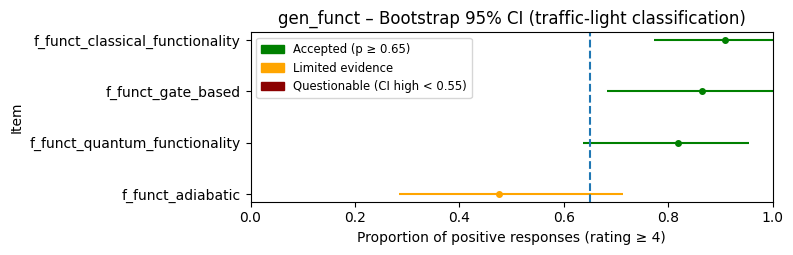

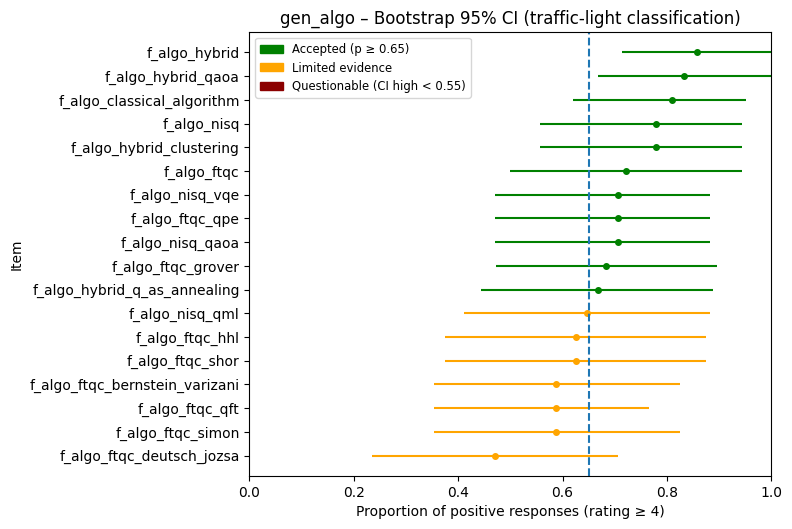

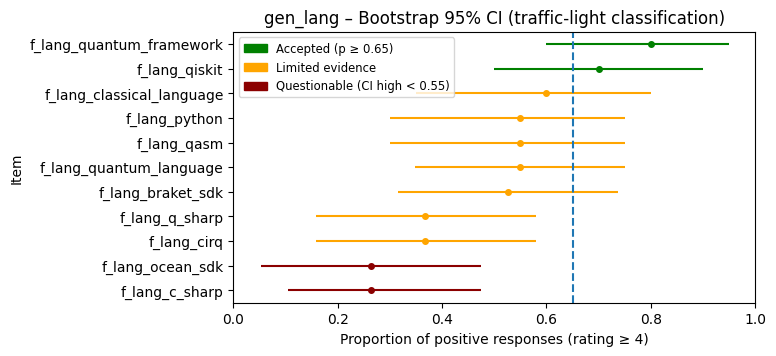

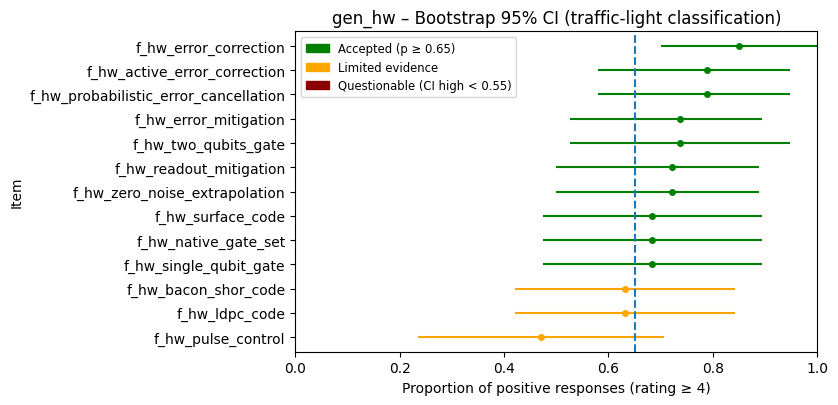

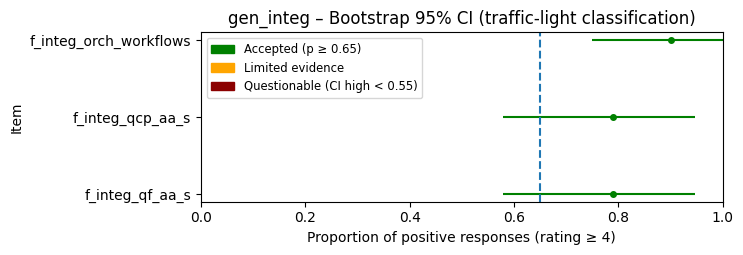

In [29]:
for group_name, df_ci_group in bootstrap_results.items():
    title = f"{group_name} – Bootstrap 95% CI (traffic-light classification)"
    plot_forest_ci(
        df_ci_group,
        title=title,
        accept_threshold=0.65,
        weak_threshold=0.55,
    )




### 5. Overall summary table of item-level reliability and stability

The following table summarises, for each feature and constraint:

- basic response statistics: `N_total`, `N_valid`, `DKNA_%`, `mean`, `median`, `sd`, `%neg`, `%neutral`, `%pos`;
- content validity: `I-CVI` (proportion of ratings ≥ 4), `%pos`, and qualitative `status` (accepted / limited / questionable);
- group-level agreement: `Fleiss_Kappa` and `Krippendorff_Alpha` (reported in subtotal rows per FM group);
- bootstrap stability: `icvi`, `icvi_CI_low`, and `icvi_CI_high` (95% bootstrap confidence interval for I-CVI).

Subtotal rows aggregate each FM group, reporting the average I-CVI, the number of items in each traffic-light class (Green/Amber/Red), and the corresponding inter-rater reliability indices.

In [30]:
import numpy as np
import pandas as pd

def classify_item_by_ci(row, accept_threshold=0.65, weak_threshold=0.55):
    """
    Classify a feature according to:
      - its point estimate of the proportion of positive responses
      - and its bootstrap CI.

    Rules (more inclusive):
        - 'accepted':
              proportion >= accept_threshold
        - 'questionable':
              prop_CI_high < weak_threshold
        - 'limited':
              all remaining cases
    """
    p = row.get("proportion", np.nan)
    ci_low = row.get("prop_CI_low", np.nan)
    ci_high = row.get("prop_CI_high", np.nan)

    if pd.isna(p) or pd.isna(ci_low) or pd.isna(ci_high):
        return "unknown"

    if p >= accept_threshold:
        return "accepted"
    elif ci_high < weak_threshold:
        return "questionable"
    else:
        return "limited"


def build_final_reliability_table(df, df_fm_agreement, groups, bootstrap_results,
                                  accept_threshold=0.65, weak_threshold=0.55):
    """
    Build a consolidated table including, for each item:

      From IRR / descriptives:
        - item, N_total, N_valid, DKNA_%, mean, median, sd, %neg, %neutral, %pos

      From I-CVI:
        - I-CVI, %pos (duplicated), status (accepted/limited/questionable)

      From IRR (point 3, group-level):
        - Fleiss_Kappa, Krippendorff_Alpha
        (only filled in subtotal rows per group)

      From bootstrap:
        - icvi, icvi_CI_low, icvi_CI_high
        (item-level, taken from bootstrap_results[group])

    Subtotals are added as separate rows after each group, using the 'item'
    column (e.g., 'Subtotal gen_funct') and aggregating over the items in that group.
    """

    all_rows = []
    n_total = len(df)

    # Precompute group-level IRR (Fleiss' Kappa and Krippendorff's Alpha)
    irr_per_group = {}
    if df_fm_agreement is not None:
        for group_name, cols in groups.items():
            cols_in_df = [c for c in cols if c in df_fm_agreement.columns]
            if not cols_in_df:
                irr_per_group[group_name] = (np.nan, np.nan)
                continue

            submatrix = df_fm_agreement[cols_in_df]
            kappa_g = fleiss_kappa_from_matrix(submatrix)
            alpha_g = krippendorff_alpha_ordinal(submatrix, n_levels=3)
            irr_per_group[group_name] = (kappa_g, alpha_g)
    else:
        for group_name in groups.keys():
            irr_per_group[group_name] = (np.nan, np.nan)

    # Build item rows and subtotals
    for group_name, items in groups.items():
        group_rows = []

        # Bootstrap table for this group (if available)
        boot_df = bootstrap_results.get(group_name, None)

        for col in items:
            if col not in df.columns:
                continue

            # Raw Likert responses (0,1,2,3,4,5,...)
            s = pd.to_numeric(df[col], errors="coerce")

            # Valid 1..5
            valid_mask = s.between(1, 5)
            s_valid = s[valid_mask]
            n_valid = int(valid_mask.sum())

            dkna_count = n_total - n_valid
            dkna_pct = 100.0 * dkna_count / n_total if n_total > 0 else np.nan

            if n_valid > 0:
                mean_val = s_valid.mean()
                median_val = s_valid.median()
                sd_val = s_valid.std(ddof=1)
                neg_pct = 100.0 * ((s_valid <= 2).sum() / n_valid)
                neut_pct = 100.0 * ((s_valid == 3).sum() / n_valid)
                pos_pct = 100.0 * ((s_valid >= 4).sum() / n_valid)
                icvi_val = (s_valid >= 4).mean()
            else:
                mean_val = median_val = sd_val = np.nan
                neg_pct = neut_pct = pos_pct = np.nan
                icvi_val = np.nan

            # Bootstrap info for this item
            icvi_boot = icvi_ci_low = icvi_ci_high = np.nan
            status = "unknown"

            if boot_df is not None and "item" in boot_df.columns:
                row_b = boot_df[boot_df["item"] == col]
                if not row_b.empty:
                    r0 = row_b.iloc[0]
                    icvi_boot = r0.get("icvi", np.nan)
                    icvi_ci_low = r0.get("icvi_CI_low", np.nan)
                    icvi_ci_high = r0.get("icvi_CI_high", np.nan)
                    # classification using bootstrap proportion + CI
                    status = classify_item_by_ci(
                        r0,
                        accept_threshold=accept_threshold,
                        weak_threshold=weak_threshold,
                    )
            # If we do not have bootstrap for this item, fall back to icvi_val
            if status == "unknown" and not np.isnan(icvi_val):
                # simple classification from point estimate
                if icvi_val >= accept_threshold:
                    status = "accepted"
                elif icvi_val < weak_threshold:
                    status = "questionable"
                else:
                    status = "limited"

            row = {
                "item": col,
                "N_total": n_total,
                "N_valid": n_valid,
                "DKNA_%": round(dkna_pct, 1) if not np.isnan(dkna_pct) else np.nan,
                "mean": round(mean_val, 3) if not np.isnan(mean_val) else np.nan,
                "median": round(median_val, 3) if not np.isnan(median_val) else np.nan,
                "sd": round(sd_val, 3) if not np.isnan(sd_val) else np.nan,
                "%neg": round(neg_pct, 1) if not np.isnan(neg_pct) else np.nan,
                "%neutral": round(neut_pct, 1) if not np.isnan(neut_pct) else np.nan,
                "%pos": round(pos_pct, 1) if not np.isnan(pos_pct) else np.nan,

                # I-CVI block
                "I-CVI": round(icvi_val, 3) if not np.isnan(icvi_val) else np.nan,
                "status": status,

                # IRR (point 3) – left blank at item level, filled only in subtotal
                "Fleiss_Kappa": np.nan,
                "Krippendorff_Alpha": np.nan,

                # Bootstrap I-CVI CI
                "icvi": round(icvi_boot, 3) if not np.isnan(icvi_boot) else np.nan,
                "icvi_CI_low": round(icvi_ci_low, 3) if not np.isnan(icvi_ci_low) else np.nan,
                "icvi_CI_high": round(icvi_ci_high, 3) if not np.isnan(icvi_ci_high) else np.nan,
            }

            group_rows.append(row)

        # Append item rows for this group
        all_rows.extend(group_rows)

        # Subtotal row for this group (using the already computed item-level rows)
        if group_rows:
            group_df = pd.DataFrame(group_rows)
            n_items = len(group_df)
            mean_icvi = group_df["I-CVI"].mean()



            # Group-level IRR from precomputed values
            kappa_g, alpha_g = irr_per_group.get(group_name, (np.nan, np.nan))

            subtotal_label = f"SUBTOTAL {group_name}"

            subtotal_row = {
                "item": subtotal_label,
                "N_total": "",
                "N_valid": "",
                "DKNA_%": "",
                "mean": "",
                "median": "",
                "sd": "",
                "%neg": "",
                "%neutral": "",
                "%pos": "",
                "I-CVI": round(mean_icvi, 3) if not np.isnan(mean_icvi) else "",
                "status": "",
                "Fleiss_Kappa": round(kappa_g, 3) if not (kappa_g is None or np.isnan(kappa_g)) else "",
                "Krippendorff_Alpha": round(alpha_g, 3) if not (alpha_g is None or np.isnan(alpha_g)) else "",
                "icvi": "",
                "icvi_CI_low": "",
                "icvi_CI_high": "",
            }

            all_rows.append(subtotal_row)

    final_df = pd.DataFrame(all_rows)
    return final_df


# Build and display the final summary table
final_reliability_table = build_final_reliability_table(
    df=df,
    df_fm_agreement=df_fm_agreement,
    groups=groups,
    bootstrap_results=bootstrap_results,
    accept_threshold=0.65,
    weak_threshold=0.55,
)

display(final_reliability_table)

# Optional: save for the paper
# final_reliability_table.to_csv(OUTPUT_DIR / "final_reliability_table.csv", index=False)


,item,N_total,N_valid,DKNA_%,mean,median,sd,%neg,%neutral,%pos,I-CVI,status,Fleiss_Kappa,Krippendorff_Alpha,icvi,icvi_CI_low,icvi_CI_high
0,f_funct_classical_functionality,23,22,4.3,4.455,5.0,1.057,9.1,0.0,90.9,0.909,accepted,NaN,NaN,0.909,0.773,1.0
1,f_funct_quantum_functionality,23,22,4.3,4.409,5.0,1.054,4.5,13.6,81.8,0.818,accepted,NaN,NaN,0.818,0.636,0.955
2,f_funct_gate_based,23,22,4.3,4.318,5.0,1.086,9.1,4.5,86.4,0.864,accepted,NaN,NaN,0.864,0.682,1.0
3,f_funct_adiabatic,23,21,8.7,3.429,3.0,1.248,19.0,33.3,47.6,0.476,limited,NaN,NaN,0.476,0.285,0.714
4,SUBTOTAL gen_funct,,,,,,,,,,0.767,,0.073,0.071,,,
5,f_algo_ftqc,23,18,21.7,4.167,4.5,0.985,5.6,22.2,72.2,0.722,accepted,NaN,NaN,0.722,0.5,0.944
6,f_algo_ftqc_deutsch_jozsa,23,17,26.1,3.235,3.0,1.348,23.5,29.4,47.1,0.471,limited,NaN,NaN,0.471,0.235,0.706
7,f_algo_ftqc_bernstein_varizani,23,17,26.1,3.588,4.0,1.46,17.6,23.5,58.8,0.588,limited,NaN,NaN,0.588,0.353,0.824
8,f_algo_ftqc_grover,23,19,17.4,3.895,4.0,0.875,5.3,26.3,68.4,0.684,accepted,NaN,NaN,0.684,0.472,0.895
9,f_algo_ftqc_simon,23,17,26.1,3.529,4.0,1.281,17.6,23.5,58.8,0.588,limited,NaN,NaN,0.588,0.353,0.824


#AQUI TERMINA

# Point 1 — Initial cleaning and descriptive analysis of constraints by category (subtree)

In this section, we perform a systematic cleaning and an initial descriptive analysis of all items that represent Feature Model constraints evaluated by experts. Constraints are of two types:

- **c_***: internal constraints within a subtree, originally measured on a 1–5 Likert scale.
- **ccc_***: cross-subtree constraints, measured on a 1–3 Likert scale.

Each item is associated with a **category or subtree** of the feature model. This category is identified from the variable name, taking the label that appears:

- immediately after `c_` or `ccc_`,  
- and before the next underscore (`_`).

are all grouped under the same category **algo**, combining in a single block both internal constraints and cross-subtree constraints associated with that subtree.

The procedure is as follows:

1. **Automatic item selection**, splitting:
   - Columns starting with `c_` (internal constraints).
   - Columns starting with `ccc_` (cross-subtree constraints).
2. **Category (subtree) identification** for each item based on its name, and assignment of this label to each constraint.
3. **Value cleaning**:
   - Detection of out-of-range responses.
   - Identification of missing / DK/NA values and computation of their percentages.
4. **Rescaling of the 1–5 Likert scale to a 1–3 scale** for `c_` constraints, using:
   - 1–2 → 1 (negative response)
   - 3 → 2 (neutral response)
   - 4–5 → 3 (positive response)
5. **Descriptive statistics per item**, on a 1–3 scale:
   - N_total, N_valid, DKNA_%
   - Percentage distribution for categories 1, 2 and 3
   - %neg, %neutral, %pos
   - Mean, median and standard deviation
6. **Aggregated descriptors by category (subtree)**, combining together `c_` and `ccc_` constraints that share the same category label. That is, all variables whose names share the same subtree tag are integrated into a single summary block.

As a result, we obtain two main tables:

- **desc_all**: combined descriptives for all constraints (type `c` and `ccc`), with their corresponding category/subtree.
- **desc_blocks**: aggregated summary by category/subtree, combining both `c_` and `ccc_` constraints for each subtree.

These tables will serve as the basis for the subsequent validity and agreement analyses (IRR, I-CVI and bootstrap).

In [31]:
# ================================================================
# POINT 1 — DESCRIPTIVES (COMBINED c_ AND ccc_) IN 1–3 SCALE
# ================================================================

import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# Identify items
# -------------------------------------------------------------------
c_cols   = [col for col in df.columns if col.startswith("c_")]
ccc_cols = [col for col in df.columns if col.startswith("ccc_")]

df_c   = df[c_cols].copy()
df_ccc = df[ccc_cols].copy()

# -------------------------------------------------------------------
# Extract subtree/categoría from naming pattern
# e.g., c_algorithm_01  → "algorithm"
#       ccc_backend_03 → "backend"
# -------------------------------------------------------------------
def extract_subtree(colname: str) -> str:
    parts = colname.split("_")
    if len(parts) > 2 and parts[0] in ("c", "ccc"):
        return parts[1]
    return ""

# -------------------------------------------------------------------
# Clean Likert-like series, keeping only declared valid values
# -------------------------------------------------------------------
def clean_likert(series, valid_vals):
    s = pd.to_numeric(series, errors="coerce")
    N_total = len(s)
    mask_valid = s.isin(valid_vals)
    N_valid = mask_valid.sum()
    dkna_pct = 100 * (N_total - N_valid) / N_total if N_total > 0 else np.nan
    s_clean = s.where(mask_valid, np.nan)
    return s_clean, {
        "N_total": N_total,
        "N_valid": int(N_valid),
        "DKNA_%": dkna_pct
    }

# -------------------------------------------------------------------
# Recoding 1–5 → 1–3 for c_ variables
# 1–2 → 1 ; 3 → 2 ; 4–5 → 3
# -------------------------------------------------------------------
def likert5_to3(x):
    if pd.isna(x):
        return np.nan
    try:
        v = int(x)
    except:
        return np.nan
    if v in (1, 2):
        return 1
    if v == 3:
        return 2
    if v in (4, 5):
        return 3
    return np.nan

# -------------------------------------------------------------------
# Compute descriptives for c_ variables (recoded)
# -------------------------------------------------------------------
records_c = []

for col in c_cols:
    subtree = extract_subtree(col)

    s_raw, info = clean_likert(df_c[col], valid_vals=[1,2,3,4,5])
    s3 = s_raw.map(likert5_to3)

    neg_pct = 100 * (s3 == 1).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan
    neu_pct = 100 * (s3 == 2).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan
    pos_pct = 100 * (s3 == 3).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan

    records_c.append({
        "item": col,
        "subtree": subtree,
        "type": "c",
        "N_total": info["N_total"],
        "N_valid": info["N_valid"],
        "DKNA_%": info["DKNA_%"],
        "%neg": neg_pct,
        "%neutral": neu_pct,
        "%pos": pos_pct
    })

desc_c = pd.DataFrame(records_c)

# -------------------------------------------------------------------
# Compute descriptives for ccc_ variables (already 1–3)
# -------------------------------------------------------------------
records_ccc = []

for col in ccc_cols:
    subtree = extract_subtree(col)

    s_raw, info = clean_likert(df_ccc[col], valid_vals=[1,2,3])

    neg_pct = 100 * (s_raw == 1).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan
    neu_pct = 100 * (s_raw == 2).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan
    pos_pct = 100 * (s_raw == 3).sum() / info["N_valid"] if info["N_valid"] > 0 else np.nan

    records_ccc.append({
        "item": col,
        "subtree": subtree,
        "type": "ccc",
        "N_total": info["N_total"],
        "N_valid": info["N_valid"],
        "DKNA_%": info["DKNA_%"],
        "%neg": neg_pct,
        "%neutral": neu_pct,
        "%pos": pos_pct
    })

desc_ccc = pd.DataFrame(records_ccc)

# -------------------------------------------------------------------
# Combine both sets
# -------------------------------------------------------------------
desc_all = pd.concat([desc_c, desc_ccc], ignore_index=True)

# Sort by subtree, type, item
desc_all = desc_all.sort_values(["subtree", "type", "item"]).reset_index(drop=True)

print("=== Descriptive table (desc_all) for c_ and ccc_ variables ===")
display(desc_all)


=== Descriptive table (desc_all) for c_ and ccc_ variables ===


,item,subtree,type,N_total,N_valid,DKNA_%,%neg,%neutral,%pos
0,c_algo_1,algo,c,23,20,13.043478,15.000000,35.000000,50.000000
1,ccc_algo_1,algo,ccc,23,19,17.391304,10.526316,21.052632,68.421053
2,ccc_algo_2,algo,ccc,23,19,17.391304,0.000000,15.789474,84.210526
3,ccc_algo_3,algo,ccc,23,19,17.391304,5.263158,10.526316,84.210526
4,ccc_algo_4,algo,ccc,23,19,17.391304,5.263158,15.789474,78.947368
5,ccc_funct_1,funct,ccc,23,21,8.695652,9.523810,28.571429,61.904762
6,ccc_funct_2,funct,ccc,23,16,30.434783,6.250000,43.750000,50.000000
7,ccc_hw_1,hw,ccc,23,20,13.043478,10.000000,30.000000,60.000000
8,ccc_hw_2,hw,ccc,23,21,8.695652,14.285714,14.285714,71.428571
9,ccc_hw_3,hw,ccc,23,19,17.391304,21.052632,10.526316,68.421053


/tmp/ipython-input-2428141714.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


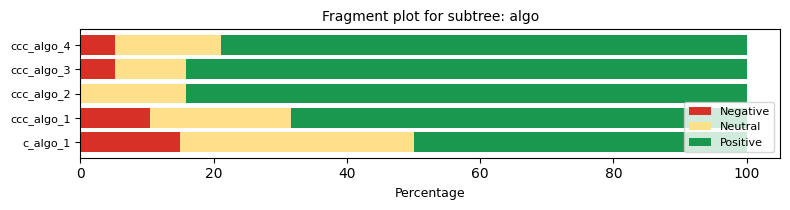

/tmp/ipython-input-2428141714.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


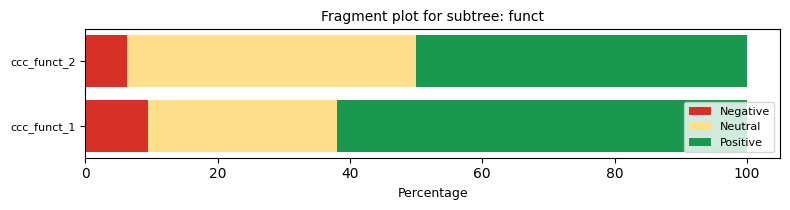

/tmp/ipython-input-2428141714.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


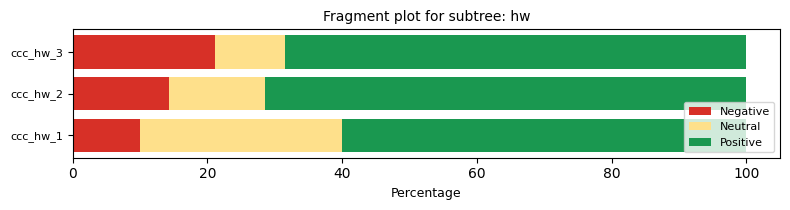

/tmp/ipython-input-2428141714.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


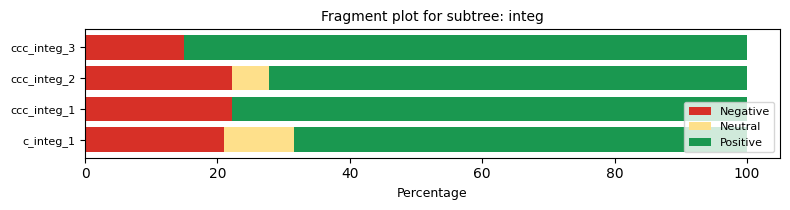

/tmp/ipython-input-2428141714.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


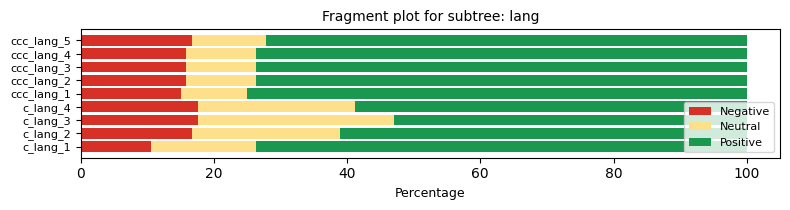

/tmp/ipython-input-2428141714.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(items, fontsize=8)


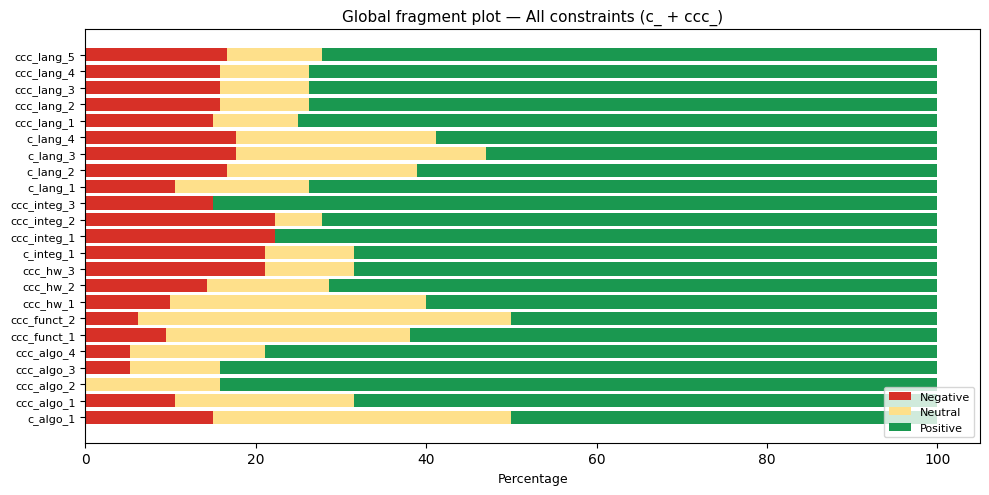

In [32]:
# ===============================================================
# 7. Fragment plots — one per subtree (COMPACT VERSION)
# ===============================================================
for subtree, df_sub in desc_all.groupby("subtree"):
    n_items = len(df_sub)
    height = max(2.2, 0.22 * n_items)   # Compact height

    fig, ax = plt.subplots(figsize=(8, height))

    items = df_sub["item"]
    neg = df_sub["%neg"]
    neu = df_sub["%neutral"]
    pos = df_sub["%pos"]

    ax.barh(items, neg, label="Negative", color="#d73027")
    ax.barh(items, neu, left=neg, label="Neutral", color="#fee08b")
    ax.barh(items, pos, left=neg + neu, label="Positive", color="#1a9850")

    ax.set_title(f"Fragment plot for subtree: {subtree}", fontsize=10)
    ax.set_xlabel("Percentage", fontsize=9)
    ax.set_yticklabels(items, fontsize=8)

    ax.legend(loc="lower right", fontsize=8)

    plt.tight_layout()
    plt.show()


# ===============================================================
# 8. Global fragment plot — All constraints (COMPACT VERSION)
# ===============================================================
df_global = desc_all.sort_values(["subtree", "type", "item"]).reset_index(drop=True)

n_items = len(df_global)
height = max(3.0, 0.22 * n_items)   # Compact height

fig, ax = plt.subplots(figsize=(10, height))

items = df_global["item"]
neg = df_global["%neg"]
neu = df_global["%neutral"]
pos = df_global["%pos"]

ax.barh(items, neg, label="Negative", color="#d73027")
ax.barh(items, neu, left=neg, label="Neutral", color="#fee08b")
ax.barh(items, pos, left=neg + neu, label="Positive", color="#1a9850")

ax.set_title("Global fragment plot — All constraints (c_ + ccc_)", fontsize=11)
ax.set_xlabel("Percentage", fontsize=9)
ax.set_yticklabels(items, fontsize=8)

ax.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()


# Point 2 — Content Validity: I-CVI per constraint and per subtree

This section evaluates the **content validity** of each constraint using the  
**Item-Level Content Validity Index (I-CVI)** on the unified 1–3 ordinal scale:

- 1 = negative evaluation  
- 2 = neutral  
- 3 = positive / acceptable

For each item (constraint), I-CVI is computed as:

\[
\text{I-CVI} = \frac{\#\text{experts with rating } = 3}{N_\text{valid}}
\]

where \(N_\text{valid}\) is the number of non-missing ratings for that item.

The interpretation (with relaxed thresholds) is:

- **I-CVI ≥ 0.65** → *Excellent* / acceptable content validity (item can be retained).  
- **0.55 ≤ I-CVI < 0.65** → *Needs revision* (semantics should be clarified or reformulated).  
- **I-CVI < 0.55** → *Rejection candidate* (insufficient support from experts).

For each item we report:

- `item`, `subtree`, `type` (c vs. ccc)  
- `N_total`, `N_valid`, `DKNA_%`  
- `%pos` (percentage of positive ratings, i.e. category 3)  
- `I_CVI`  
- `status` (categorical interpretation based on the thresholds above)

In addition, we compute a **block-level Content Validity Index** per subtree (S-CVI/Ave):

- **S-CVI/Ave** = mean I-CVI across all items in the subtree

This provides an aggregated measure of how well each subtree is supported by expert judgments, combining both internal (`c_`) and cross-subtree (`ccc_`) constraints.

The resulting tables are:

- `icvi_table`: item-level content validity indices  
- `icvi_blocks`: subtree-level S-CVI/Ave, plus a global S-CVI/Ave across all constraints


In [33]:
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# 1. Item selection (same logic as in Point 1)
# ----------------------------------------------------------
c_cols   = [col for col in df.columns if col.startswith("c_")]
ccc_cols = [col for col in df.columns if col.startswith("ccc_")]

df_c   = df[c_cols].copy()
df_ccc = df[ccc_cols].copy()

def get_subtree_from_name(col_name: str) -> str:
    """
    Extract the subtree/category name from the column name.
    Assumes pattern:
      c_<SUBTREE>_...
      ccc_<SUBTREE>_...
    """
    parts = col_name.split("_")
    if len(parts) >= 2 and parts[0] in ("c", "ccc"):
        return parts[1]
    return parts[0] if parts else col_name

# ----------------------------------------------------------
# 2. Basic cleaning and rescaling (for c_ items)
# ----------------------------------------------------------
def clean_likert(series, valid_vals):
    """
    Clean a Likert-type series:
    - Cast to numeric
    - Mark values outside valid_vals as NaN
    Returns cleaned series and basic info dict.
    """
    s = pd.to_numeric(series, errors="coerce")
    N_total = len(s)
    mask_valid = s.isin(valid_vals)
    N_valid = mask_valid.sum()
    dkna_pct = 100 * (N_total - N_valid) / N_total if N_total > 0 else np.nan
    s_clean = s.where(mask_valid, np.nan)
    return s_clean, {
        "N_total": N_total,
        "N_valid": int(N_valid),
        "DKNA_%": dkna_pct
    }

def likert5_to3(x):
    """
    Map 1–5 Likert scale into 1–3:
      1–2 -> 1 (negative)
      3   -> 2 (neutral)
      4–5 -> 3 (positive)
    """
    if pd.isna(x):
        return np.nan
    try:
        x = int(x)
    except Exception:
        return np.nan
    if x in (1, 2):
        return 1
    if x == 3:
        return 2
    if x in (4, 5):
        return 3
    return np.nan

def classify_icvi(icvi, th1=0.55, th2=0.65):
    """
    Classify I-CVI values into status categories using relaxed thresholds:
      I-CVI >= th2      -> excellent
      th1 <= I-CVI < th2 -> needs_revision
      I-CVI < th1       -> reject
    """
    if pd.isna(icvi):
        return "insufficient_data"
    if icvi >= th2:
        return "excellent"
    if icvi >= th1:
        return "needs_revision"
    return "reject"

# ----------------------------------------------------------
# 3. Compute I-CVI for c_ items (originally 1–5, rescaled to 1–3)
# ----------------------------------------------------------
records = []

for col in c_cols:
    subtree = get_subtree_from_name(col)
    s_clean_5, info_5 = clean_likert(df_c[col], valid_vals=[1, 2, 3, 4, 5])
    s_3 = s_clean_5.map(likert5_to3)  # 1–3 scale

    N_valid = s_3.notna().sum()
    if N_valid > 0:
        n_pos = (s_3 == 3).sum()
        icvi = n_pos / N_valid
        pos_pct = 100 * n_pos / N_valid
    else:
        icvi = np.nan
        pos_pct = np.nan

    status = classify_icvi(icvi)

    records.append({
        "item": col,
        "subtree": subtree,
        "type": "c",
        "N_total": info_5["N_total"],
        "N_valid": int(N_valid),
        "DKNA_%": info_5["DKNA_%"],
        "%pos": pos_pct,
        "I_CVI": icvi,
        "status": status
    })

# ----------------------------------------------------------
# 4. Compute I-CVI for ccc_ items (already 1–3)
# ----------------------------------------------------------
for col in ccc_cols:
    subtree = get_subtree_from_name(col)
    s_clean_3, info_3 = clean_likert(df_ccc[col], valid_vals=[1, 2, 3])

    N_valid = s_clean_3.notna().sum()
    if N_valid > 0:
        n_pos = (s_clean_3 == 3).sum()
        icvi = n_pos / N_valid
        pos_pct = 100 * n_pos / N_valid
    else:
        icvi = np.nan
        pos_pct = np.nan

    status = classify_icvi(icvi)

    records.append({
        "item": col,
        "subtree": subtree,
        "type": "ccc",
        "N_total": info_3["N_total"],
        "N_valid": int(N_valid),
        "DKNA_%": info_3["DKNA_%"],
        "%pos": pos_pct,
        "I_CVI": icvi,
        "status": status
    })

# ----------------------------------------------------------
# 5. Build I-CVI table (per item) and block-level summary
# ----------------------------------------------------------
icvi_table = pd.DataFrame(records)
icvi_table = icvi_table.sort_values(["subtree", "type", "item"]).reset_index(drop=True)

print("=== I-CVI per item (c_ and ccc_) ===")
display(icvi_table)

# S-CVI/Ave per subtree
icvi_blocks = (
    icvi_table
    .groupby("subtree")["I_CVI"]
    .mean(numeric_only=True)
    .reset_index()
    .rename(columns={"I_CVI": "S_CVI_Ave"})
    .sort_values("subtree")
)

# Global S-CVI/Ave (all items)
global_scvi_ave = icvi_table["I_CVI"].mean(skipna=True)

print("=== S-CVI/Ave by subtree ===")
display(icvi_blocks)

print(f"=== Global S-CVI/Ave across all constraints: {global_scvi_ave:.3f} ===")


=== I-CVI per item (c_ and ccc_) ===


,item,subtree,type,N_total,N_valid,DKNA_%,%pos,I_CVI,status
0,c_algo_1,algo,c,23,20,13.043478,50.000000,0.500000,reject
1,ccc_algo_1,algo,ccc,23,19,17.391304,68.421053,0.684211,excellent
2,ccc_algo_2,algo,ccc,23,19,17.391304,84.210526,0.842105,excellent
3,ccc_algo_3,algo,ccc,23,19,17.391304,84.210526,0.842105,excellent
4,ccc_algo_4,algo,ccc,23,19,17.391304,78.947368,0.789474,excellent
5,ccc_funct_1,funct,ccc,23,21,8.695652,61.904762,0.619048,needs_revision
6,ccc_funct_2,funct,ccc,23,16,30.434783,50.000000,0.500000,reject
7,ccc_hw_1,hw,ccc,23,20,13.043478,60.000000,0.600000,needs_revision
8,ccc_hw_2,hw,ccc,23,21,8.695652,71.428571,0.714286,excellent
9,ccc_hw_3,hw,ccc,23,19,17.391304,68.421053,0.684211,excellent


=== S-CVI/Ave by subtree ===


,subtree,S_CVI_Ave
0,algo,0.731579
1,funct,0.559524
2,hw,0.666165
3,integ,0.758553
4,lang,0.683150


=== Global S-CVI/Ave across all constraints: 0.694 ===


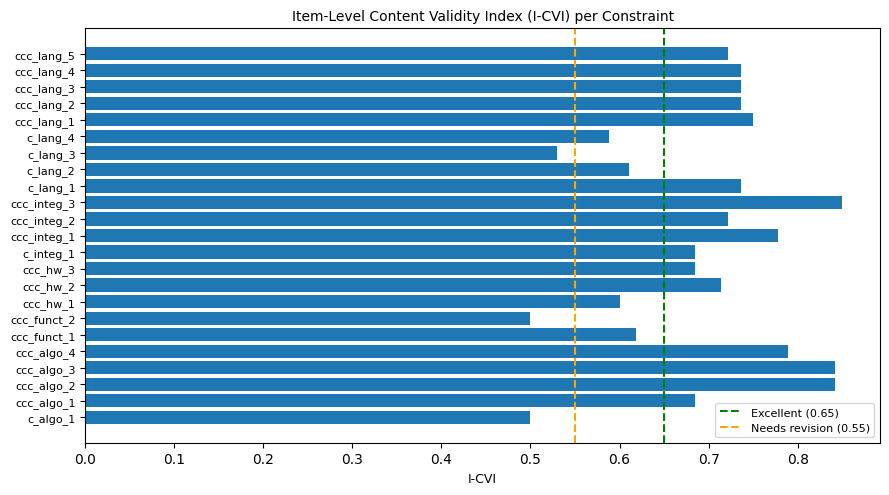

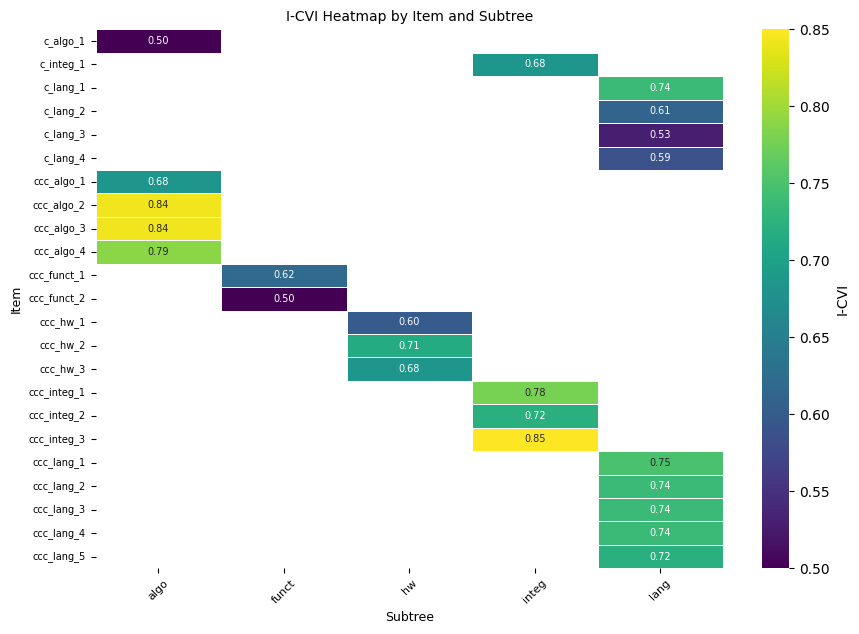

In [34]:
# ================================================================
# VISUALIZATIONS FOR I-CVI — COMPACT BARPLOT + COMPACT HEATMAP
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = icvi_table.sort_values(
    ["subtree", "type", "item"],
    ascending=[True, True, True]
).reset_index(drop=True)

# ----------------------------------------------------------
# 1. Horizontal barplot of I-CVI per item (COMPACT)
# ----------------------------------------------------------
n_items = len(df_plot)
height = max(3.0, 0.22 * n_items)   # compact height

plt.figure(figsize=(9, height))

plt.barh(df_plot["item"], df_plot["I_CVI"], color="#1f78b4")

# Threshold lines
plt.axvline(0.65, color="green", linestyle="--", label="Excellent (0.65)")
plt.axvline(0.55, color="orange", linestyle="--", label="Needs revision (0.55)")

plt.xlabel("I-CVI", fontsize=9)
plt.title("Item-Level Content Validity Index (I-CVI) per Constraint", fontsize=10)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 2. Heatmap of I-CVI by item and subtree (COMPACT)
# ----------------------------------------------------------
heatmap_df = icvi_table.pivot(index="item", columns="subtree", values="I_CVI")

n_items = len(heatmap_df)
height = max(3.0, 0.28 * n_items)   # compact height

plt.figure(figsize=(9, height))

sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="viridis",
    fmt=".2f",
    cbar_kws={"label": "I-CVI"},
    linewidths=0.5,
    annot_kws={"fontsize": 7}
)

plt.title("I-CVI Heatmap by Item and Subtree", fontsize=10)
plt.xlabel("Subtree", fontsize=9)
plt.ylabel("Item", fontsize=9)
plt.yticks(fontsize=7)
plt.xticks(fontsize=8, rotation=45)
plt.tight_layout()
plt.show()



# Point 3 — Inter-Rater Reliability (IRR) by Category/Subtree

This section evaluates the agreement among experts for each of the five major categories (subtrees) of the Feature Model.  
Unlike Fleiss’ Kappa, which is well-defined at the item level, Krippendorff’s Alpha (ordinal) cannot be computed for a single item because its denominator requires variability across multiple units. Therefore:

- **Fleiss’ Kappa** is computed at the *item level* and then averaged within each subtree.
- **Krippendorff’s Alpha (ordinal)** is computed at the *subtree level*, using all items of that subtree as “units”, which is the correct statistical formulation.

## Indicators computed per subtree
For each of the five subtrees, two indicators are reported:

1. **Fleiss’ Kappa (average across items of the subtree)**  
   - Measures categorical agreement between experts.  
   - Sensitive to marginal distributions (e.g., strong skew in responses reduces Kappa).

2. **Krippendorff’s Alpha (ordinal)**  
   - Measures reliability of ordinal ratings (1–3).  
   - Handles missing values naturally.  
   - Uses ordinal distances, therefore capturing disagreement severity.

Together, these indicators provide a robust view of the strength and consistency of expert judgments for each block of constraints.

## Interpretation guidelines

### **Fleiss’ Kappa (κ)**
General interpretation (Landis & Koch, 1977):
- **κ < 0.00** → Poor agreement  
- **0.00–0.20** → Slight  
- **0.21–0.40** → Fair  
- **0.41–0.60** → Moderate  
- **0.61–0.80** → Substantial  
- **0.81–1.00** → Almost perfect  

Since constraints often have skewed category usage, Kappa tends to be **conservative**.

### **Krippendorff’s Alpha (ordinal)**
Standard interpretation:
- **α ≥ 0.80** → Strong reliability  
- **0.67 ≤ α < 0.80** → Tentative / acceptable  
- **α < 0.67** → Insufficient reliability  

Alpha is more robust than Kappa and is not biased by skewed marginal distributions, so it provides a clearer picture of semantic coherence within each subtree.

## Heatmap
A heatmap summarises, for each subtree:

- The average Fleiss’ Kappa  
- Krippendorff’s Alpha (ordinal)

This visualization helps identify:
- **Highly reliable blocks** (high κ and α)  
- **Blocks with moderate consensus** (mid-range values)  
- **Problematic or ambiguous blocks** (low κ and α)  

These indicators guide revision decisions in the next sections (content validity, I-CVI, etc.).


=== IRR by subtree (Fleiss' Kappa + Krippendorff's Alpha) ===


,subtree,Fleiss_Kappa,Krippendorff_Alpha
0,algo,-0.066667,NaN
1,funct,-0.058333,NaN
2,hw,-0.052729,NaN
3,integ,-0.092570,NaN
4,lang,-0.111590,NaN


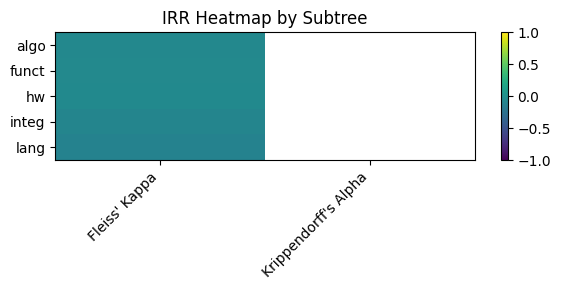

In [35]:
# ================================================================
# IRR BY SUBTREE: Fleiss' Kappa (mean per block) + Alpha (ordinal)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa

# ----------------------------------------------------------
# 1. Fleiss' Kappa per item (already available in irr_table)
# ----------------------------------------------------------

# If irr_table was not created yet, regenerate minimally:
def compute_fleiss_kappa_single(series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return np.nan
    cats = [1, 2, 3]
    table = np.zeros((len(s), len(cats)))
    for i, val in enumerate(s):
        if val in cats:
            table[i, cats.index(val)] = 1
    # Convert to category-counts matrix
    count_matrix = np.array([table[:, j].sum() for j in range(len(cats))])
    mat = np.array([count_matrix])
    try:
        return float(fleiss_kappa(mat))
    except:
        return np.nan

records = []
for item in desc_all["item"]:
    s = df[item]
    s_clean = pd.to_numeric(s, errors="coerce")
    kappa = compute_fleiss_kappa_single(s_clean)
    records.append({
        "item": item,
        "subtree": desc_all.set_index("item").loc[item, "subtree"],
        "type": desc_all.set_index("item").loc[item, "type"],
        "Fleiss_Kappa": kappa
    })

irr_items = pd.DataFrame(records)

# Average Fleiss' Kappa per subtree
kappa_blocks = (
    irr_items.groupby("subtree")["Fleiss_Kappa"]
    .mean(numeric_only=True)
    .reset_index()
    .sort_values("subtree")
)

# ----------------------------------------------------------
# 2. Krippendorff’s Alpha (ordinal) per subtree
# ----------------------------------------------------------
def compute_alpha_matrix(df_matrix):
    data = df_matrix.to_numpy()
    try:
        return float(krippendorff.alpha(
            reliability_data=data,
            level_of_measurement='ordinal'
        ))
    except:
        return np.nan

alpha_records = []

df_items_numeric = df[desc_all["item"]].apply(pd.to_numeric, errors="coerce")

for subtree, group in desc_all.groupby("subtree"):
    cols = group["item"].tolist()
    df_sub = df_items_numeric[cols]
    alpha_sub = compute_alpha_matrix(df_sub.T)
    alpha_records.append({"subtree": subtree, "Krippendorff_Alpha": alpha_sub})

alpha_blocks = pd.DataFrame(alpha_records).sort_values("subtree").reset_index(drop=True)

# ----------------------------------------------------------
# 3. Combine both indicators
# ----------------------------------------------------------
irr_blocks = pd.merge(kappa_blocks, alpha_blocks, on="subtree")

print("=== IRR by subtree (Fleiss' Kappa + Krippendorff's Alpha) ===")
display(irr_blocks)

# ----------------------------------------------------------
# 4. Heatmap of IRR indicators by subtree
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 0.6 * len(irr_blocks)))

heatmap_data = irr_blocks.set_index("subtree")[["Fleiss_Kappa", "Krippendorff_Alpha"]]

im = ax.imshow(heatmap_data, aspect='auto', cmap="viridis", vmin=-1, vmax=1)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Fleiss' Kappa", "Krippendorff's Alpha"], rotation=45, ha="right")
ax.set_yticks(range(len(heatmap_data)))
ax.set_yticklabels(heatmap_data.index)

ax.set_title("IRR Heatmap by Subtree")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


# Point 4 — Bootstrap Confidence Intervals for I-CVI

This section estimates the **stability** of the Item-Level Content Validity Index (I-CVI) using **non-parametric bootstrap resampling**.

For each constraint (item), we repeatedly resample expert ratings with replacement and recompute I-CVI. This produces a bootstrap distribution from which we extract:

- **I-CVI_boot**: bootstrap mean  
- **I-CVI_CI_low**: 2.5th percentile  
- **I-CVI_CI_high**: 97.5th percentile  

These intervals provide information about:

### 1. Stability of the consensus
Narrow confidence intervals indicate consistent judgments; wide intervals suggest heterogeneity or uncertainty among experts.

### 2. Robustness with respect to the relaxed thresholds (0.55 and 0.65)

- **CI entirely ≥ 0.65** → the item shows strong and stable content validity.  
- **CI entirely < 0.55** → the item is not supported even under uncertainty; revision or removal is recommended.  
- **CI overlapping the [0.55, 0.65] region** → the item is borderline: it may be acceptable but fragile and should be examined in detail.

### 3. Sensitivity to sample size
Bootstrap compensates for the relatively small number of raters typical in expert validation studies, providing more reliable inferences about I-CVI.

The final output includes:

- `icvi_bootstrap_table`: item-level bootstrap estimates and confidence intervals  
- A combined table joining raw I-CVI, bootstrap results and classification  
- A “forest plot” visualisation with point estimates and confidence intervals for all items


In [36]:
# ================================================================
# UPDATED CLASSIFICATION (SEPARATED COLUMNS + NEW THRESHOLDS)
# Thresholds: 0.55 (lower), 0.65 (upper)
# Two status columns: status_base, status_ci
# ================================================================
import numpy as np
import pandas as pd

# ----------------------------------------------------------------
# 0. Ensure icvi_bootstrap_table exists; if not, compute it here
# ----------------------------------------------------------------
if "icvi_bootstrap_table" not in globals():
    print("icvi_bootstrap_table not found — computing bootstrap table now...")

    B = 10000  # number of bootstrap iterations
    bootstrap_records = []

    for _, row in icvi_table.iterrows():
        item = row["item"]
        subtree = row["subtree"]
        type_ = row["type"]

        # Extract ratings for this item
        s = pd.to_numeric(df[item], errors="coerce").dropna()
        if s.empty:
            bootstrap_records.append({
                "item": item,
                "subtree": subtree,
                "type": type_,
                "I_CVI_boot": np.nan,
                "I_CVI_CI_low": np.nan,
                "I_CVI_CI_high": np.nan
            })
            continue

        positive = (s == 3).astype(int)
        N = len(positive)

        boot_icvi = []
        for _ in range(B):
            sample = positive.sample(N, replace=True)
            boot_icvi.append(sample.mean())

        boot_icvi = np.array(boot_icvi)

        bootstrap_records.append({
            "item": item,
            "subtree": subtree,
            "type": type_,
            "I_CVI_boot": boot_icvi.mean(),
            "I_CVI_CI_low": np.percentile(boot_icvi, 2.5),
            "I_CVI_CI_high": np.percentile(boot_icvi, 97.5)
        })

    icvi_bootstrap_table = pd.DataFrame(bootstrap_records)
    print("Bootstrap table 'icvi_bootstrap_table' created.")
    display(icvi_bootstrap_table.head())

# ----------------------------------------------------------------
# 1. Merge raw I-CVI with bootstrap results
# ----------------------------------------------------------------
icvi_full = pd.merge(
    icvi_table,
    icvi_bootstrap_table,
    on=["item", "subtree", "type"],
    how="left"
)

# ----------------------------------------------------------------
# 2. Base status from I-CVI (Point 3) with 0.55 / 0.65
# ----------------------------------------------------------------
def classify_base(icvi, th1=0.55, th2=0.65):
    if pd.isna(icvi):
        return "insufficient_data"
    if icvi >= th2:
        return "excellent"
    if icvi >= th1:
        return "needs_revision"
    return "reject"

icvi_full["status_base"] = icvi_full["I_CVI"].apply(classify_base)

# ----------------------------------------------------------------
# 3. CI-based status (Point 4) with 0.55 / 0.65
# ----------------------------------------------------------------
def classify_by_ci(row, th1=0.55, th2=0.65):
    low = row["I_CVI_CI_low"]
    high = row["I_CVI_CI_high"]

    if pd.isna(low) or pd.isna(high):
        return "insufficient_data"

    if low >= th2:
        return "robust_valid"
    if high < th1:
        return "not_supported"
    return "borderline"

icvi_full["status_ci"] = icvi_full.apply(classify_by_ci, axis=1)

# ----------------------------------------------------------------
# 4. Optional final combined label
# ----------------------------------------------------------------
def combine(row):
    return f"{row['status_base']} | {row['status_ci']}"

icvi_full["status_final"] = icvi_full.apply(combine, axis=1)

# ----------------------------------------------------------------
# 5. Sorting and display
# ----------------------------------------------------------------
icvi_full = icvi_full.sort_values(
    ["subtree", "type", "item"]
).reset_index(drop=True)

print("=== Combined I-CVI + Bootstrap + Updated Status (55/65 thresholds) ===")
display(icvi_full)


icvi_bootstrap_table not found — computing bootstrap table now...
Bootstrap table 'icvi_bootstrap_table' created.


,item,subtree,type,I_CVI_boot,I_CVI_CI_low,I_CVI_CI_high
0,c_algo_1,algo,c,0.304778,0.130435,0.478261
1,ccc_algo_1,algo,ccc,0.565170,0.347826,0.739130
2,ccc_algo_2,algo,ccc,0.695648,0.521739,0.869565
3,ccc_algo_3,algo,ccc,0.694330,0.478261,0.869565
4,ccc_algo_4,algo,ccc,0.650870,0.434783,0.826087


=== Combined I-CVI + Bootstrap + Updated Status (55/65 thresholds) ===


,item,subtree,type,N_total,N_valid,DKNA_%,%pos,I_CVI,status,I_CVI_boot,I_CVI_CI_low,I_CVI_CI_high,status_base,status_ci,status_final
0,c_algo_1,algo,c,23,20,13.043478,50.000000,0.500000,reject,0.304778,0.130435,0.478261,reject,not_supported,reject | not_supported
1,ccc_algo_1,algo,ccc,23,19,17.391304,68.421053,0.684211,excellent,0.565170,0.347826,0.739130,excellent,borderline,excellent | borderline
2,ccc_algo_2,algo,ccc,23,19,17.391304,84.210526,0.842105,excellent,0.695648,0.521739,0.869565,excellent,borderline,excellent | borderline
3,ccc_algo_3,algo,ccc,23,19,17.391304,84.210526,0.842105,excellent,0.694330,0.478261,0.869565,excellent,borderline,excellent | borderline
4,ccc_algo_4,algo,ccc,23,19,17.391304,78.947368,0.789474,excellent,0.650870,0.434783,0.826087,excellent,borderline,excellent | borderline
5,ccc_funct_1,funct,ccc,23,21,8.695652,61.904762,0.619048,needs_revision,0.564909,0.347826,0.782609,needs_revision,borderline,needs_revision | borderline
6,ccc_funct_2,funct,ccc,23,16,30.434783,50.000000,0.500000,reject,0.347735,0.173913,0.565217,reject,borderline,reject | borderline
7,ccc_hw_1,hw,ccc,23,20,13.043478,60.000000,0.600000,needs_revision,0.521904,0.304348,0.695652,needs_revision,borderline,needs_revision | borderline
8,ccc_hw_2,hw,ccc,23,21,8.695652,71.428571,0.714286,excellent,0.654000,0.434783,0.826087,excellent,borderline,excellent | borderline
9,ccc_hw_3,hw,ccc,23,19,17.391304,68.421053,0.684211,excellent,0.563600,0.347826,0.782609,excellent,borderline,excellent | borderline


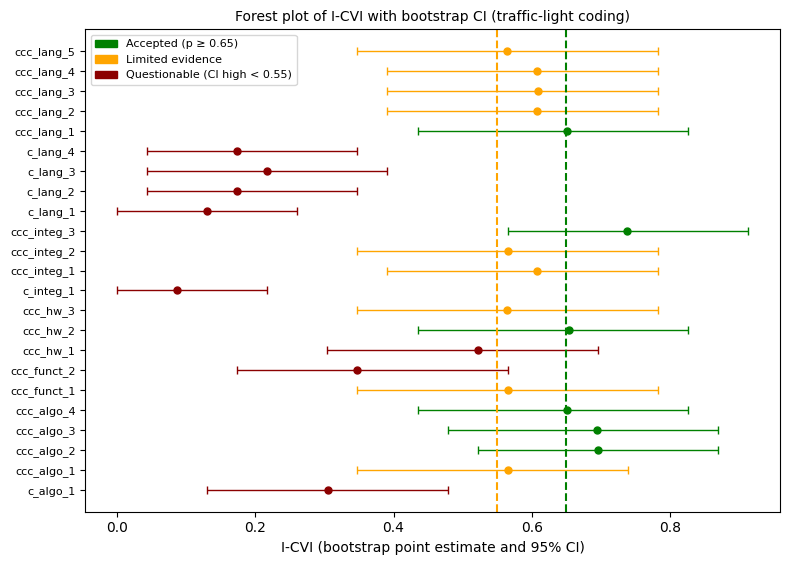

In [37]:
# ================================================================
# COMPACT FOREST PLOT WITH TRAFFIC-LIGHT COLORS AND SCIENTIFIC LEGEND
# Thresholds: 0.55 (weak) / 0.65 (accept)
# ================================================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

accept_threshold = 0.65
weak_threshold   = 0.55

plot_df = icvi_full.copy()

# Fallback on I_CVI if bootstrap point is missing
plot_df["I_CVI_point"] = np.where(
    plot_df["I_CVI_boot"].notna(),
    plot_df["I_CVI_boot"],
    plot_df["I_CVI"]
)

plot_df = plot_df.sort_values(["subtree", "type", "item"]).reset_index(drop=True)

# -----------------------------------------------------------------------
# Assign colors to the POINT estimate only (traffic-light logic)
# -----------------------------------------------------------------------
def get_point_color(point):
    if pd.isna(point):
        return "grey"
    if point >= accept_threshold:
        return "green"
    if point >= weak_threshold:
        return "orange"
    return "darkred"

plot_df["color"] = plot_df["I_CVI_point"].apply(get_point_color)

# -----------------------------------------------------------------------
# Figure size: as compact as possible, but readable
# Height proportional to number of items, with a small minimum
# -----------------------------------------------------------------------
n_items = len(plot_df)
height = max(3.5, 0.25 * n_items)   # 0.25 per item, but not less than 3.5
fig, ax = plt.subplots(figsize=(8, height))

y_positions = np.arange(n_items)

# -----------------------------------------------------------------------
# Plot each item: point + CI
# -----------------------------------------------------------------------
for i, row in plot_df.iterrows():
    point = row["I_CVI_point"]
    low   = row["I_CVI_CI_low"]
    high  = row["I_CVI_CI_high"]
    color = row["color"]

    if pd.isna(point) or pd.isna(low) or pd.isna(high):
        continue

    ax.errorbar(
        x=point,
        y=i,
        xerr=[[point - low], [high - point]],
        fmt="o",
        color=color,
        ecolor=color,
        capsize=3,
        markersize=5,
        linewidth=1
    )

# Threshold reference lines
ax.axvline(accept_threshold, linestyle="--", color="green")
ax.axvline(weak_threshold,   linestyle="--", color="orange")

ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df["item"], fontsize=8)
ax.set_xlabel("I-CVI (bootstrap point estimate and 95% CI)")
ax.set_title("Forest plot of I-CVI with bootstrap CI (traffic-light coding)", fontsize=10)

# -----------------------------------------------------------------------
# Legend with requested labels (upper left)
# -----------------------------------------------------------------------
legend_elements = [
    Patch(color="green",   label=f"Accepted (p ≥ {accept_threshold:.2f})"),
    Patch(color="orange",  label="Limited evidence"),
    Patch(color="darkred", label=f"Questionable (CI high < {weak_threshold:.2f})"),
]

ax.legend(handles=legend_elements, loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()


#AQUI TERMINA

##**8.** Categorical Variables

In [38]:
#@title Frequency tables for categorical variables (edit COLS accordingly)
CATEGORICAL_COLS = ["phase", "role", "exp_q", "exp_spl", "qc_areas", "country"]  # e.g., ["role", "country", "framework_primary"]
freq_tables = {}
for col in CATEGORICAL_COLS:
    vc = df[col].value_counts(dropna=False)
    freq_tables[col] = vc
    print("\n=== {} ===".format(col))
    display(vc)


=== phase ===


,count
phase,
"Analysis, Design",10
"Analysis, Design, Coding, Testing, Execution",3
Analysis,2
"Analysis, Design, Coding, Testing",2
"Design, Testing",2
"Analysis, Design, Coding",1
"Design, Coding",1
"Design, Execution",1
"Design, Testing, Execution",1



=== role ===


,count
role,
Academia,19
"Academia, Industry",2
Industry,2



=== exp_q ===


,count
exp_q,
Intermediate (1-3 years),11
Advanced (3-5 years),9
Beginner (0-1 years),2
Expert (7+ years),1



=== exp_spl ===


,count
exp_spl,
Beginner (0-1 years),12
Intermediate (1-3 years),5
Advanced (3-5 years),4
Expert (7+ years),2



=== qc_areas ===


,count
qc_areas,
"Quantum Software Engineering, Hybrid Classical-Quantum Software Development",4
"Quantum Software Engineering, Quantum Algorithms, Quantum Software Testing",2
Quantum Software Engineering,2
"Quantum Software Engineering, Hybrid Classical-Quantum Software Development, Quantum Software Testing, Quantum Machine Learning",2
"Hybrid Classical-Quantum Software Development, Quantum Optimization, Quantum Machine Learning",1
Quantum Machine Learning,1
Quantum Error Correction,1
"Quantum Algorithms, Quantum Error Correction, Qunatum Networking",1
"Quantum Algorithms, Quantum Machine Learning",1



=== country ===


,count
country,
NaN,9
Spain,4
Japan,2
Chile,2
Germany,1
Italy,1
New Zealand,1
Luxembourg,1
Portugal,1


## 6. Reliability analysis (Cronbach's alpha)

**Purpose.** Cronbach’s alpha (α) estimates the **internal consistency** (reliability) of a set of items intended to measure the same construct. Higher α suggests that items share common variance and move together as a scale.

**Computation.** $For (k) items (X_1,dots,X_k) scored numerically (e.g., Likert), and after listwise deletion of missing values, we compute:
[
\alpha = \frac{k}{k-1}\Bigg(1 - \frac{\sum_{i=1}^{k} s_i^2}{s_T^2}\Bigg)], where (s_i^2) is the sample variance of item (i), and (s_T^2) is the variance of the **row-wise sum** (T = \sum_i X_i).$

**Interpretation (rules of thumb, not hard cutoffs).**
- **≥ 0.90**: Excellent  
- **0.80–0.89**: Good  
- **0.70–0.79**: Acceptable  
- **0.60–0.69**: Questionable  
- **0.50–0.59**: Poor  
- **< 0.50**: Unacceptable

**Reading the results table.**
- **construct**: name of the latent variable you defined.  
- **k_items**: number of items in the construct (≥ 2 required).  
- **n_used**: number of responses used **after** listwise NA removal.  
- **alpha**: Cronbach’s α (rounded to three decimals in the display).  
- **interpretation**: qualitative label per the thresholds above.  
- **notes**: quick guidance (e.g., possible item redundancy if α>0.95; consider item review if α<0.70).

**Good practice and caveats.**
- α assumes **tau-equivalence** and is sensitive to the **number of items** and **item variance** (longer scales often inflate α).  
- A very high α (>0.95) can indicate **redundant items**.  
- A low α may reflect **heterogeneous content**, **few items**, or **restricted variance** (e.g., ceiling effects).  
- Always complement α with **item diagnostics** (e.g., item–total correlations, α if item deleted), **factor analysis**, and external **validity** checks.

**Tip for Colab rendering.** Use a Markdown cell (not a code cell) to render LaTeX like \(\alpha\) and \(\hat{p}\). If generating Markdown from Python, wrap strings as raw literals (e.g., `r"""..."""`) to preserve backslashes.


In [39]:
# --- Build CONSTRUCTS from previously computed `groups` and (optionally) compute Cronbach’s alpha ---
# All code and comments in English.

import pandas as pd
from IPython.display import display, Markdown

def _pretty_construct_name(group_key: str) -> str:
    """
    Turn a group key like 'gen_process' into a readable construct name: 'Process'.
    Keeps a short descriptor; you can adapt this to your naming conventions.
    """
    key = str(group_key)
    if key.startswith("gen_"):
        key = key[4:]
    return key.replace("_", " ").strip().title()

# 1) Build CONSTRUCTS directly from `groups` (features only, since c_* were already ignored)
CONSTRUCTS = {}
for gname, cols in groups.items():
    # gname is the 'gen_*' column (group header). Use a pretty label for readability.
    pretty = _pretty_construct_name(gname)
    # Only keep non-empty lists
    if cols:
        CONSTRUCTS[pretty] = list(cols)

# 2) Show a compact preview of the constructs (name -> #items)
if not CONSTRUCTS:
    display(Markdown("> **No constructs built from `groups`.** Check that `groups` is non-empty."))
else:
    display(Markdown("### Constructs built from `groups`"))
    preview_rows = [{"construct": k, "k_items": len(v)} for k, v in CONSTRUCTS.items()]
    display(pd.DataFrame(preview_rows).sort_values("construct").reset_index(drop=True))

# 3) If `cronbach_alpha` is defined in the notebook, compute interpreted α per construct
if "cronbach_alpha" in globals():
    def _interpret_alpha(a: float) -> str:
        if pd.isna(a): return "NA"
        if a >= 0.90: return "Excellent"
        if a >= 0.80: return "Good"
        if a >= 0.70: return "Acceptable"
        if a >= 0.60: return "Questionable"
        if a >= 0.50: return "Poor"
        return "Unacceptable"

    records = []
    for name, cols in CONSTRUCTS.items():
        # Coerce to numeric and perform listwise deletion within the construct
        sub = df[cols].apply(pd.to_numeric, errors="coerce")
        sub_clean = sub.dropna(axis=0, how="any")
        k_items = len(cols)
        n_used = len(sub_clean)
        a = cronbach_alpha(sub_clean) if (k_items > 1 and n_used > 1) else float("nan")
        note = ""
        if pd.isna(a):
            note = "Insufficient items/variance or too many missing values."
        elif a < 0.70:
            note = "Consider reviewing items; check item–total correlations."
        elif a > 0.95:
            note = "Possible redundancy among items."

        records.append({
            "construct": name,
            "k_items": k_items,
            "n_used": n_used,
            "alpha": a,
            "interpretation": _interpret_alpha(a),
            "notes": note
        })

    res = pd.DataFrame.from_records(records)
    if not res.empty:
        res_disp = res.copy()
        res_disp["alpha"] = res_disp["alpha"].round(3)
        display(Markdown("### Cronbach’s alpha by construct (interpreted)"))
        display(res_disp[["construct", "k_items", "n_used", "alpha", "interpretation", "notes"]]
                .sort_values(["alpha"], ascending=[False], na_position="last")
                .reset_index(drop=True))
else:
    display(Markdown("> `cronbach_alpha` is not defined in the current scope. "
                     "Define it first to compute reliability for these constructs."))


### Constructs built from `groups`

,construct,k_items
0,Algo,18
1,Funct,4
2,Hw,13
3,Integ,3
4,Lang,11


> `cronbach_alpha` is not defined in the current scope. Define it first to compute reliability for these constructs.

###McDonald’s Omega (ω total)

In [40]:
# === McDonald's Omega (ω) per construct with real per-branch n and missing-data handling ===
# Works in Google Colab. Assumes `df` (responses DataFrame) and `CONSTRUCTS` (dict: name -> list of columns) exist.

!pip -q install factor-analyzer

import numpy as np
import pandas as pd
from itertools import combinations
from IPython.display import display, Markdown

# Optional: MINRES (requires complete cases per construct)
from factor_analyzer import FactorAnalyzer

# ----------------------------
# Configuration
# ----------------------------
# If True, always use PCA-based omega on Spearman (pairwise) -> leverages all available data (recommended with small n).
# If False, try MINRES on rank-transformed data (complete cases); on failure, fallback to PCA.
FORCE_PCA_ONLY = True

# ----------------------------
# Utilities
# ----------------------------
def _interpret_omega(w: float) -> str:
    if pd.isna(w): return "NA"
    if w >= 0.90: return "Excellent"
    if w >= 0.80: return "Good"
    if w >= 0.70: return "Acceptable"
    if w >= 0.60: return "Questionable"
    return "Poor/Unacceptable"

def _pairwise_min_n(df_sub: pd.DataFrame) -> int:
    """Minimum number of non-missing pairs across all item pairs (support for pairwise Spearman)."""
    cols = df_sub.columns.tolist()
    if len(cols) == 0:
        return 0
    if len(cols) == 1:
        return int(df_sub[cols[0]].notna().sum())
    mins = []
    for a, b in combinations(cols, 2):
        mins.append(int(df_sub[[a, b]].dropna(how="any").shape[0]))
    return min(mins) if mins else 0

def _omega_from_loadings_uniqueness(loadings: np.ndarray, uniqueness: np.ndarray) -> float:
    loadings = np.asarray(loadings).flatten()
    uniqueness = np.asarray(uniqueness).flatten()
    if np.any(~np.isfinite(loadings)) or np.any(~np.isfinite(uniqueness)):
        return np.nan
    uniqueness = np.clip(uniqueness, 0.0, None)
    num = (np.sum(loadings))**2
    den = num + np.sum(uniqueness)
    return float(num / den) if den > 0 else np.nan

def _omega_pca_fallback(df_sub: pd.DataFrame) -> float:
    """
    PCA-based omega on Spearman correlation (pairwise).
    For 1-factor approximation: λ_i = sqrt(eig1) * v1_i, ψ_i = 1 - λ_i^2 (since R is a correlation matrix).
    """
    # Pairwise Spearman correlation
    R = df_sub.corr(method="spearman").to_numpy()
    # Symmetrize, clip, set diag to 1
    R = (R + R.T) / 2.0
    np.fill_diagonal(R, 1.0)
    R = np.clip(R, -1.0, 1.0)

    # Eigen-decomposition
    vals, vecs = np.linalg.eigh(R)
    idx = np.argsort(vals)[::-1]
    eig1 = float(vals[idx[0]])
    v1 = vecs[:, idx[0]]
    # First component loadings
    loadings = np.sqrt(max(eig1, 0.0)) * v1
    communality = np.clip(loadings**2, 0.0, 1.0)
    uniqueness = 1.0 - communality
    return _omega_from_loadings_uniqueness(loadings, uniqueness)

def _omega_minres_on_ranks(df_complete: pd.DataFrame) -> float:
    """
    Fit 1-factor MINRES on rank-transformed data (Pearson on ranks ≈ Spearman).
    Requires complete cases for the selected items.
    """
    ranked = df_complete.rank(method="average")
    fa = FactorAnalyzer(n_factors=1, rotation=None, method="minres")
    fa.fit(ranked.values)
    loadings = fa.loadings_.flatten()
    uniqueness = fa.get_uniquenesses().flatten()
    return _omega_from_loadings_uniqueness(loadings, uniqueness)

def _compute_omega_for_construct(df: pd.DataFrame, cols: list, force_pca: bool = True):
    """
    Returns (omega, n_used, note).
    - If force_pca: uses PCA on Spearman (pairwise), n_used = min pairwise n among item pairs.
    - Else: tries MINRES on complete cases; if fails, fallback to PCA; n_used reported accordingly.
    """
    sub = df[cols].apply(pd.to_numeric, errors="coerce")
    k_items = len(cols)

    if k_items < 2:
        return np.nan, 0, "Insufficient items (<2)."

    # Availability
    n_total = len(sub)
    n_complete = len(sub.dropna(how="any"))
    n_min_pair = _pairwise_min_n(sub)

    if force_pca:
        if n_min_pair < 4:
            return np.nan, n_min_pair, "Too few responses (pairwise) for ω."
        try:
            w = _omega_pca_fallback(sub)
            note = "PCA (pairwise Spearman)."
            if np.isfinite(w) and w > 0.95:
                note += " Possible redundancy among items."
            elif np.isfinite(w) and w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_min_pair, note
        except Exception as e:
            return np.nan, n_min_pair, f"Estimation failed (PCA): {e}"

    # MINRES route (complete cases), then fallback
    if n_complete >= 4:
        try:
            w = _omega_minres_on_ranks(sub.dropna(how="any"))
            note = "MINRES on ranks (complete cases)."
            if not np.isfinite(w):
                raise RuntimeError("MINRES returned non-finite ω.")
            if w > 0.95:
                note += " Possible redundancy among items."
            elif w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_complete, note
        except Exception as e:
            # Fallback to PCA (pairwise)
            try:
                w = _omega_pca_fallback(sub)
                note = f"PCA fallback (MINRES failed: {e})."
                if np.isfinite(w) and w > 0.95:
                    note += " Possible redundancy among items."
                elif np.isfinite(w) and w < 0.70:
                    note += " Low common variance; consider reviewing items."
                return w, n_min_pair, note
            except Exception as e2:
                return np.nan, n_min_pair, f"Estimation failed (both MINRES and PCA): {e}; fallback: {e2}"
    else:
        # Not enough complete cases; use PCA (pairwise)
        if n_min_pair < 4:
            return np.nan, n_min_pair, "Too few responses (pairwise) for ω."
        try:
            w = _omega_pca_fallback(sub)
            note = "PCA (pairwise Spearman) due to insufficient complete cases."
            if np.isfinite(w) and w > 0.95:
                note += " Possible redundancy among items."
            elif np.isfinite(w) and w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_min_pair, note
        except Exception as e:
            return np.nan, n_min_pair, f"Estimation failed (PCA): {e}"

# ----------------------------
# Run: availability + omega by construct
# ----------------------------
if "CONSTRUCTS" not in globals() or not isinstance(CONSTRUCTS, dict) or len(CONSTRUCTS) == 0:
    display(Markdown("> **No constructs available.** Please build `CONSTRUCTS` first."))
else:
    # Availability diagnostics
    rows_diag = []
    for name, cols in CONSTRUCTS.items():
        sub = df[cols].apply(pd.to_numeric, errors="coerce")
        rows_diag.append({
            "construct": name,
            "k_items": len(cols),
            "n_total_rows": len(sub),
            "n_complete_rows": len(sub.dropna(how='any')),
            "n_min_pairwise": _pairwise_min_n(sub),
        })
    diag_df = pd.DataFrame(rows_diag).sort_values("construct").reset_index(drop=True)
    display(Markdown("### Availability per construct"))
    display(diag_df)

    # Omega computation
    records = []
    for name, cols in CONSTRUCTS.items():
        w, n_used, note = _compute_omega_for_construct(df, cols, force_pca=FORCE_PCA_ONLY)
        records.append({
            "construct": name,
            "k_items": len(cols),
            "n_used": n_used,
            "omega_total": w,
            "interpretation": _interpret_omega(w),
            "notes": note
        })

    res = pd.DataFrame.from_records(records)
    if not res.empty:
        res_disp = res.copy()
        # Round omega for display
        if "omega_total" in res_disp:
            res_disp["omega_total"] = res_disp["omega_total"].round(3)
        display(Markdown("### McDonald’s Omega (ω total) by construct"))
        display(res_disp.sort_values(["omega_total"], ascending=[False], na_position="last").reset_index(drop=True))

    # Reminder for small n
    if not res.empty and (res["n_used"] < 30).any():
        display(Markdown(
            "> **Note:** Given the small effective n per construct, treat ω as exploratory and "
            "report the per-branch n used (pairwise/complete) alongside results."
        ))


### Availability per construct

,construct,k_items,n_total_rows,n_complete_rows,n_min_pairwise
0,Algo,18,23,23,23
1,Funct,4,23,23,23
2,Hw,13,23,23,23
3,Integ,3,23,23,23
4,Lang,11,23,23,23


### McDonald’s Omega (ω total) by construct

,construct,k_items,n_used,omega_total,interpretation,notes
0,Algo,18,23,0.973,Excellent,PCA (pairwise Spearman). Possible redundancy a...
1,Integ,3,23,0.969,Excellent,PCA (pairwise Spearman). Possible redundancy a...
2,Lang,11,23,0.964,Excellent,PCA (pairwise Spearman). Possible redundancy a...
3,Hw,13,23,0.961,Excellent,PCA (pairwise Spearman). Possible redundancy a...
4,Funct,4,23,0.866,Good,PCA (pairwise Spearman).


> **Note:** Given the small effective n per construct, treat ω as exploratory and report the per-branch n used (pairwise/complete) alongside results.

## 7. Cross-tabs & basic significance tests

In [41]:

#@title Chi-square tests for association (categorical x categorical)
PAIRS_CATEG = []  # e.g., [("role", "framework_primary")]
for a, b in PAIRS_CATEG:
    ct = pd.crosstab(df[a], df[b])
    chi2, p, dof, exp = stats.chi2_contingency(ct.fillna(0))
    print("\n{} vs {}".format(a, b))
    display(ct)
    print("chi2={:.3f}, dof={}, p={:.4f}".format(chi2, dof, p))


In [42]:

#@title T-test / ANOVA for numeric outcomes (edit as needed)
# Example: Does perceived usefulness differ by role?
# OUTCOME = "fm_var_mgmt"
# GROUP = "role"
# dropna_rows = df[[OUTCOME, GROUP]].dropna()
# groups = [vals[OUTCOME].astype(float).values for _, vals in dropna_rows.groupby(GROUP)]
# if len(groups) > 1:
#     f, p = stats.f_oneway(*groups)
#     print("ANOVA: F={:.3f}, p={:.4f}".format(f, p))
# else:
#     print("Not enough groups for ANOVA")


## 8. Publication-ready tables & figures

In [43]:

#@title Example: Likert stacked bar (5-point)
# Provide a helper to transform Likert columns to percentages per label
LIKERT_ORDER = [1, 2, 3, 4, 5]  # after mapping to numeric
LIKERT_LABELS = ["Strongly disagree","Disagree","Neutral","Agree","Strongly agree"]

def likert_table(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    # expects numeric 1..5
    table = []
    for c in cols:
        counts = df[c].value_counts().reindex(LIKERT_ORDER, fill_value=0)
        perc = (counts / counts.sum() * 100).round(1)
        row = perc.rename(c)
        table.append(row)
    out = pd.DataFrame(table, columns=LIKERT_ORDER)
    out.columns = LIKERT_LABELS
    return out

# Example usage:
LIKERT_COLS = []  # e.g., ["fm_var_mgmt", "fm_algo_select", "fm_integration"]
if LIKERT_COLS:
    tbl = likert_table(df, LIKERT_COLS)
    display(tbl)
    tbl.to_csv(OUTPUT_DIR / "likert_table.csv")


In [44]:

#@title Plot: Likert stacked bars
def plot_likert_stacked(table: pd.DataFrame, title: str = "Perception of FM"):
    # table columns should be ordered as LIKERT_LABELS
    ax = table.plot(kind="bar", stacked=True, figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Item")
    plt.ylabel("Percentage")
    plt.legend(title="Response", bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    out = OUTPUT_DIR / ("likert_stacked_" + title.replace(" ", "_").lower() + ".png")
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

# Example:
# if LIKERT_COLS:
#     tbl = likert_table(df, LIKERT_COLS)
#     plot_likert_stacked(tbl, title="Usefulness of the Feature Model")


## 9. Reproducibility

In [45]:

#@title Save session info and a minimal requirements file
import platform, subprocess

session = {
    "python": sys.version,
    "platform": platform.platform(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "scipy": stats.__version__ if hasattr(stats, '__version__') else None,
    "statsmodels": sm.__version__,
    "gspread": HAS_GSPREAD,
}
with open(OUTPUT_DIR / "session_info.json", "w") as f:
    json.dump(session, f, indent=2)
print(json.dumps(session, indent=2))

# Minimal requirements (edit as needed)
req = """
pandas
numpy
matplotlib
scipy
statsmodels
gspread
gspread-dataframe
"""
with open(OUTPUT_DIR / "requirements.txt", "w") as f:
    f.write(req.strip() + "\n")
print("Wrote:", OUTPUT_DIR / "requirements.txt")


{
  "python": "3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]",
  "platform": "Linux-6.6.105+-x86_64-with-glibc2.35",
  "pandas": "2.2.2",
  "numpy": "2.0.2",
  "matplotlib": "3.10.0",
  "scipy": null,
  "statsmodels": "0.14.5",
  "gspread": true
}
Wrote: /content/outputs/requirements.txt



## Appendix: Paper-oriented narrative (to fill in)

### A. Research Questions (RQs)
- RQ1: *To what extent does the proposed Feature Model cover variability in functionalities, algorithms, frameworks and integration models for hybrid Q–C systems?*
- RQ2: *What is the perceived usefulness and ease of use of the Feature Model among QSE experts?*
- RQ3: *Which factors (e.g., role, experience, domain) explain differences in adoption intent?*

### B. Method
- Instrument: Google Forms survey (include sections and sample items).
- Participants: N=..., sampling & inclusion criteria.
- Measures: Likert items grouped in constructs; open-ended items.
- Analysis: Reliability (Cronbach’s alpha), descriptive stats, cross-tabs & significance tests.

### C. Results
- Response flow and demographics.
- Construct reliability and descriptive stats.
- Key figures: Likert stacked bars; histograms; cross-tabs.

### D. Discussion
- Alignment with prior QSE/SPL research; implications for Feature Models in hybrid Q–C systems.
- Threats to validity: construct, internal, external, conclusion validity.
- Limitations and future work.

### E. Reuse in the paper
Export figures from `/content/outputs` and reference them in the manuscript. Tables (CSV) can be loaded into LaTeX or Word tables.
